## Optimizing Personalized Treatment Strategies for Acute Hypotensive Patients

Description of Environment:

1. State Space: The state space represents the current condition of the patient which includes:
    * Vital signs: Heart rate, systolic and diastolic blood pressure, respiratory rate, oxygen saturation, etc.
    * Biochemical markers: Blood pH, lactate levels, creatinine, and other lab results that provide insights into organ function
    * Demographics and medical history: Patient age, gender, weight, comorbidities (e.g. diabetes, renal failure)
    * Previous treatment: Prior medication dosages and fluid levels administered during the current ICU stay. 

2. Action Space: Discrete treatment actions that a clinician could take to manage acute hypotension in ICU patients. This may include: 
    * Fluid Administration (e.g. low, medium, high dosage)
    * Vasopressor administration (e.g. low, medium, high dosage)
    * No intervention (wait and observe)
    Each of these actions will have an immediate impact on the patient’s state (e.g. vital signs, biochemical markers), making it crucial to optimize the sequence of actions based on the patient’s evolving condition. 

3. Reward Function: The reward at time step $t$ is dependent on the Mean Arterial Pressure $MAP_t$ and is given by:

$$\text{reward}_t = \begin{cases}
0 & \text{if MAP$_t > 65$} \\
\frac{-0.05(65-\text{MAP}_t)}{5} & \text{if $60 < \text{MAP}_t \le 65$} \\
\frac{-0.1(60-\text{MAP}_t)}{5}-0.05 & \text{if $55 < \text{MAP}_t \le 60$} \\
\frac{-0.85(55-\text{MAP}_t)}{15}-0.15 & \text{if $\text{MAP}_t \le 55$} \\
\end{cases}$$

But the reward value is also dictated, and overwritten by the urine output at time step t:

$$\text{reward}_t = 0 \text{ if urine}_t >30\text{ and MAP}_t >55$$

The objective of the project is to develop an AI-based decision support system that assists clinicians in personalizing treatment strategies for acute hypotension. We will :

* Learn to recommend optimal treatments based on patient-specific data, adapting in real-time to their evolving condition.
* Compare the performance of model-free approaches with model-based techniques to identify which provides more reliable and clinically relevant reccomendations
* Use off-policy evaluation methods such as weighted importance sampling and bootstrapping to ensure safe and effective policies without real-world deployment. 


---

### 0. Split Train Test

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# load data
df = df = pd.read_csv('Data/C001_FakeHypotension.csv')
print(f'Number of unique patients: {df["PatientID"].nunique()}')
num_patients = df['PatientID'].nunique()

# rename columns
df.rename(columns={"PatientID": "id", "Timepoints": "hour"}, inplace=True)

Number of unique patients: 3910


In [3]:
# reward function
def reward_function(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

# add the reward to the data
df['reward'] = df.apply(lambda row: reward_function(row), axis=1)
# shift one up so that reward is in the same row of action
df['reward'] = df['reward'].shift(-1)

In [4]:
# encode action to action number
fluid_boluses_dict = {
    **dict.fromkeys([0, 1, 2, 3], '[0, 250)'),
    **dict.fromkeys([4, 5, 6, 7], '[250, 500)'),
    **dict.fromkeys([8, 9, 10, 11], '[500, 1000)'),
    **dict.fromkeys([12, 13, 14, 15], '>= 1000')
}
vasopressors_dict = {
    **dict.fromkeys([0, 4, 8, 12], '0'),
    **dict.fromkeys([1, 5, 9, 13], '(0, 8.4)'),
    **dict.fromkeys([2, 6, 10, 14], '[8.4, 20.28)'),
    **dict.fromkeys([3, 7, 11, 15], '>= 20.28')
}

fluid_boluses_mapping = {v:i for i,v in enumerate(sorted(df['fluid_boluses'].unique()))}
vasopressors_mapping = {v:i for i,v in enumerate(sorted(df['vasopressors'].unique()))}
df['fluid_boluses'] = df['fluid_boluses'].map(fluid_boluses_mapping)
df['vasopressors'] = df['vasopressors'].map(vasopressors_mapping)
df['action_number'] = 4 * df['fluid_boluses'] + df['vasopressors']

In [5]:
# split train test
seed = 42
np.random.seed(seed)

train_ratio = 0.8
num_train_samples = int(num_patients * train_ratio)
train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
print(f'Number of patients in train data: {len(train_ids)}')

train_df = df[df["id"].isin(train_ids)].reset_index(drop=True)
test_df = df[~df["id"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_df.shape}')
print(f'Test Data: {test_df.shape}')

Number of patients in train data: 3128
Train Data: (150144, 25)
Test Data: (37536, 25)


### 1. Tabular Q-Learning (Following HealthGym's tutorial)

Prepare data:

In [777]:
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSCanonical

In [778]:
# columns for states and actions
actions = ["fluid_boluses", "vasopressors"]
state_columns = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
          "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

In [779]:
# cross decomposition to reduce dimensionality
train_df_state = train_df[state_columns]
train_df_action = train_df[actions]
train_df_action = pd.get_dummies(train_df_action, prefix=["fluid_boluses", "vasopressors"], columns=["fluid_boluses", "vasopressors"])

# partial least squares regression
plsca = PLSCanonical(n_components=5)

X = train_df_state.astype(float).values
Y = train_df_action.astype(float).values
X_norm = (X - X.mean(axis=0)) / (X.std(axis=0))
Y_norm = (Y - Y.mean(axis=0)) / (Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

Finding optimal number of clusters...


100%|██████████| 16/16 [07:05<00:00, 26.60s/it]


Optimal number of clusters: 190
Davies-Bouldin score: 1.3177


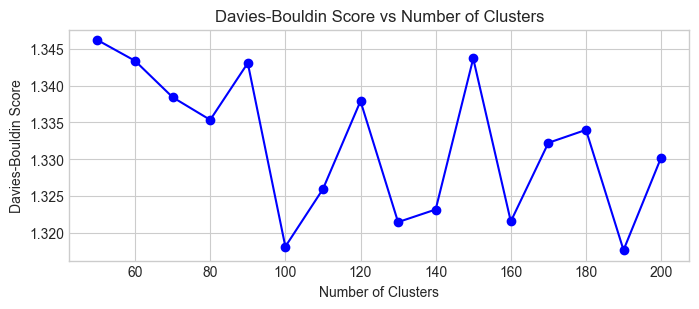

In [ ]:
def find_optimal_clusters(X, max_clusters=200, min_clusters=50, step=10):
    """
    Find optimal number of clusters using Davies-Bouldin score.
    
    Args:
        X: array-like of shape (n_samples, n_features)
        max_clusters: Maximum number of clusters to try
        min_clusters: Minimum number of clusters to try
        step: Step size between number of clusters to try
    
    Returns:
        dict: Dictionary containing:
            'optimal_n_clusters': Optimal number of clusters
            'scores': List of Davies-Bouldin scores
            'n_clusters': List of number of clusters tried
    """
    from sklearn.metrics import davies_bouldin_score
    import numpy as np
    from tqdm import tqdm
    
    print("Finding optimal number of clusters...")
    
    # Initialize lists to store results
    db_scores = []
    n_clusters_list = range(min_clusters, max_clusters + 1, step)
    
    # Try different numbers of clusters
    for n_clusters in tqdm(n_clusters_list):
        kmeans = KMeans(
            n_clusters=n_clusters,
            n_init=10,
            random_state=123
        )
        
        # Fit and get labels
        labels = kmeans.fit_predict(X)
        
        # Calculate Davies-Bouldin score
        db_score = davies_bouldin_score(X, labels)
        db_scores.append(db_score)
    
    # Find optimal number of clusters (minimum score)
    optimal_idx = np.argmin(db_scores)
    optimal_n_clusters = n_clusters_list[optimal_idx]
    
    print(f"\nOptimal number of clusters: {optimal_n_clusters}")
    print(f"Davies-Bouldin score: {db_scores[optimal_idx]:.4f}")
    
    return {
        'optimal_n_clusters': optimal_n_clusters,
        'scores': db_scores,
        'n_clusters': list(n_clusters_list)
    }

# Usage
results = find_optimal_clusters(X_canonical)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))
plt.plot(results['n_clusters'], results['scores'], 'b-', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Use optimal number of clusters
#optimal_kmeans = KMeans(
#    n_clusters=results['optimal_n_clusters'],
#    n_init=10,
#    random_state=123
#)
#state_numbers = optimal_kmeans.fit_predict(X_canonical)

In [782]:
# k-means clustering to assign each patient to 1 cluster
num_states = 100
kmeans = KMeans(n_clusters=num_states, n_init=10, random_state=123)

state_numbers = kmeans.fit(X_canonical).labels_

We add the following variables:
* `hour`: time point between 0 and 47
* `action_number`: number between 0 and 15 indicating the action taken
* `state_number`: cluster asociated with the state at time t
* `state_number_tp1`: cluster associated with the state at time t+1

In [784]:
# add state number
X_train = train_df.copy()

X_train['state_number'] = state_numbers
X_train['state_number_tp1'] = X_train['state_number'].shift(-1)

X_train.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,GCS_total_m,PO2_m,lactic_acid_m,serum_creatinine_m,id,hour,reward,action_number,state_number,state_number_tp1
0,0,67.964940,56.709198,144.578430,241.00052,24.226444,23.811718,83.46306,1.477299,0.893153,...,1,0,0,0,0,0,0.00000,0,66,11.0
1,1,63.603493,53.635162,143.283780,230.52171,23.933348,30.188170,120.01681,1.733099,0.862924,...,0,0,0,0,0,1,0.00000,0,11,53.0
2,2,65.750670,56.904236,143.534000,217.76741,21.803823,26.318861,84.16420,1.375228,0.819521,...,0,0,0,0,0,2,-0.73454,0,53,79.0
3,3,44.684580,41.952940,117.236534,291.90466,33.613720,24.136852,102.35325,1.252799,0.754315,...,0,0,0,0,0,3,0.00000,0,79,50.0
4,4,61.486233,63.960106,111.537060,435.26230,45.407272,23.192320,63.73771,1.845126,1.155209,...,1,0,0,0,0,4,0.00000,0,50,94.0


In [785]:
# ignore last hour since we don't observe reward of the last state
X_train = X_train[X_train["hour"] < 47]
X_train["state_number_tp1"] = X_train["state_number_tp1"].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). It determines an optimal policy in a way similar to standard Q-learning, except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [ ]:
# q-learning
Q = np.full((100, 16), np.nan, dtype='float') # 100 states, 16 actions

# Set to 0 if state-action combination has actually been observed in the data
for index, row in X_train.iterrows():
    state_number = int(row['state_number'])
    action_number = int(row['action_number'])
    Q[state_number, action_number] = 0

# parameters
num_iterations = 100
step_size = 0.1
gamma = 0.99
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    for index, row in X_train.iterrows():
        state_number = int(row['state_number'])
        action_number = int(row['action_number'])
        state_number_tp1 = int(row['state_number_tp1'])
        Q[state_number, action_number] += step_size * (row['reward'] + gamma * np.nanmax(Q[state_number_tp1, :]) - Q[state_number, action_number])
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))

    if (Q_iter > 0) and (Q_iter % 10 == 0):
        print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

[Step 10] Difference in Q-values: 0.0008336227756463999


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(diff_tracker 'b-', marker='o')
plt.xlabel('Iterations')
plt.ylabel('Diff')
plt.title('Difference in Q-Values')
plt.grid(True)
plt.show()

**Evaluation**

The expected value of the RL policy can now be compared to the value of the original clinical policy or a random policy. The expected value of the RL policy is higher than for the other policies.

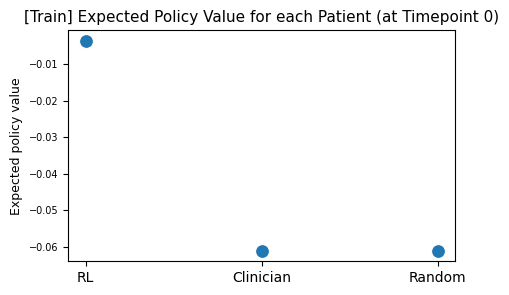

In [16]:
# evaluation on training data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_train.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value', size=9)
plt.title('[Train] Expected Policy Value for each Patient (at Timepoint 0)', size=11)
plt.tick_params(axis="y", labelsize=7)
plt.show()

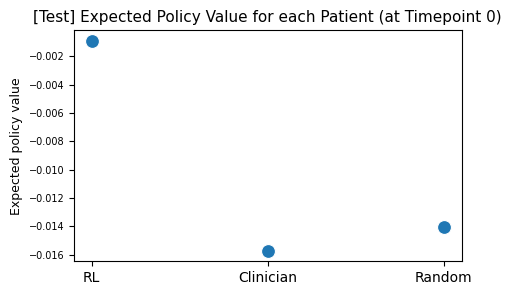

In [18]:
# normalize the test data
test_df_state = test_df[state_columns]
X_test_state = test_df_state.astype(float).values
X_test_norm = (X_test_state - X.mean(axis=0)) / X.std(axis=0)

# apply PLSCanonical to test data
X_test_canonical = plsca.transform(X_test_norm)

# apply k-means to get state numbers
test_state_numbers = kmeans.predict(X_test_canonical)

# add state numbers to test data
X_test = test_df.copy()
X_test["state_number"] = test_state_numbers

# evaluation on test data
Q_RL = 0
Q_random = 0
Q_clinician = 0

for index, row in X_test.iterrows():
    if row["hour"] == 0:
        # rl policy
        Q_RL += np.nanmax(Q[int(row['state_number']), :])

        # clinician policy
        Q_clinician += Q[int(row['state_number']), int(row['action_number'])]
        
        # random policy
        h = Q[int(row['state_number']), :]
        h = h[~np.isnan(h)]
        Q_random += h[np.random.choice(h.shape[0], 1)][0]

Q_RL = Q_RL / num_patients
Q_clinician = Q_clinician / num_patients
Q_random = Q_random / num_patients

plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], markers='s', s=100)
plt.ylabel('Expected policy value', size=9)
plt.title('[Test] Expected Policy Value for each Patient (at Timepoint 0)', size=11)
plt.tick_params(axis='y', labelsize=7)
plt.show()

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_19719/1642850234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_19719/1642850234.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_19719/1642850234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

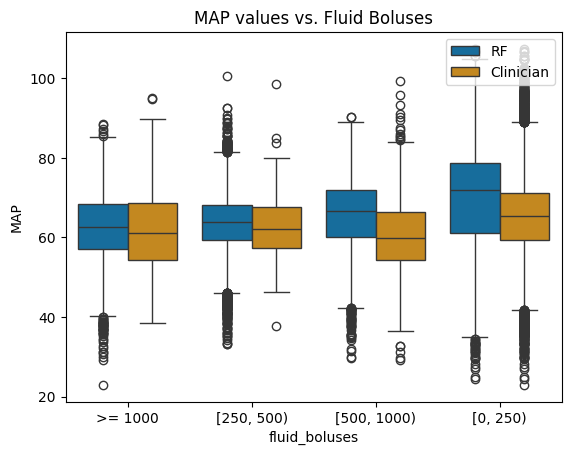

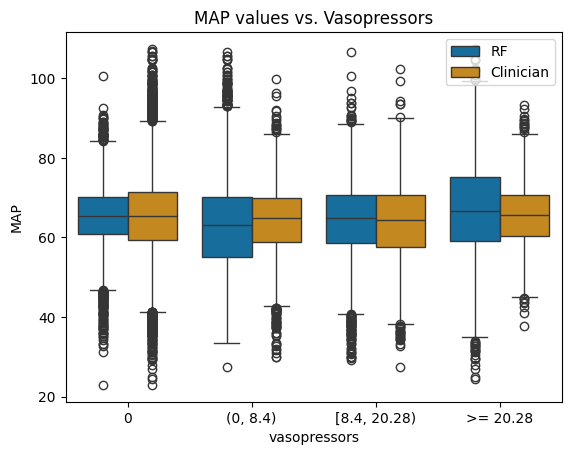

In [19]:
# MAP values for each action taken (test data)
df_boxplot_RF = X_test[['MAP']]
df_boxplot_RF['action_number'] = 0
for index, row in X_test.iterrows():
    df_boxplot_RF.at[index, 'action_number'] = np.nanargmax(Q[int(row['state_number']), :])

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = X_test[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="colorblind", hue='agent')
plt.legend(loc="upper right")
plt.title("MAP values vs. Fluid Boluses")
plt.show()

sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="colorblind", hue='agent', order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right")
plt.title("MAP values vs. Vasopressors")
plt.show()

---

### 2. Discrete Batch Constrained Deep Q-Learning



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from collections import deque

Preprocess data - scale the state columns:

In [9]:
# transform the train and test data
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(train_df[state_columns]), columns=state_columns)
X_test_scaled = pd.DataFrame(scaler.transform(test_df[state_columns]), columns=state_columns)

# add the necessary columns back
cols = ["id", "hour", "reward", "action_number"]
for col in cols:
    X_scaled[col] = train_df[col]
    X_test_scaled[col] = test_df[col]

Create a replay buffer and store all transitions:

In [15]:
# replay buffer method
class ReplayBuffer:
    def __init__(self, max_size=1000000, batch_size=64):
        self.buffer = deque(maxlen=max_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        # convert to tensors
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )

    def __len__(self):
        return len(self.buffer)

In [16]:
# store the transitions in the training data into the replay buffer
replay_buffer = ReplayBuffer()

for idx, row in X_scaled.iterrows():
    # terminal state, we don't observe reward, ignore
    if row["hour"] == 47: 
        continue
    else:
        id = row["id"]
        hour = row["hour"]

        state = np.array(row[state_columns].values)
        action = int(row["action_number"])
        reward = row["reward"]

        next_state_row = X_scaled[(X_scaled["id"]==id) & (X_scaled["hour"]==hour+1)]
        next_state = np.array(next_state_row[state_columns].values[0])
        done = 0

        replay_buffer.add(state, action, reward, next_state, done)

Set up the offline RL agent:

In [12]:
# get the theoretical bounds of the q-values (we clamp the q-values for better convergence)
gamma = 0.99
v_min = X_scaled['reward'].min() / (1 - gamma)
v_max = X_scaled['reward'].max() / (1 - gamma)
print(f'Theoretical bounds of q-values: [{v_min}, {v_max}]')

Theoretical bounds of q-values: [-216.77837199999976, 0.0]


In [25]:
# behavior cloning model - outputs a distribution over the 16 discrete actions
class BehaviorCloning(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(BehaviorCloning, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    
class Q_Network(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, v_min=v_min, v_max=v_max):
        super(Q_Network, self).__init__()
        self.v_min= v_min
        self.v_max = v_max
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        # weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight, -1e-2, 1e-2)  # Small weights for output layer
        nn.init.uniform_(self.fc3.bias, -1e-2, 1e-2)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.clamp(x, min=self.v_min, max=self.v_max)
    

# BCQ for discrete actions
class DiscreteBCQ:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, bcq_threshold=0.3, target_update_steps=5000, device="mps"):
        self.gamma = gamma
        self.threshold = bcq_threshold
        self.target_update_steps = target_update_steps
        self.device = device

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.target_q_network = Q_Network(state_dim, action_dim, hidden_dim).to(device)
        self.behavior_model = BehaviorCloning(state_dim, action_dim, hidden_dim).to(device)

        self.q_optimizer = optim.Adam(self.q_network.parameters(), lr=1e-4)
        self.behavior_optimizer = optim.Adam(self.behavior_model.parameters(), lr=1e-4)

        # copy weights to target model
        self.target_q_network.load_state_dict(self.q_network.state_dict())

        # losses
        self.q_losses = []
        self.behavior_losses = []
        self.losses = []

    def select_action(self, states):
        # select action according to policy
        with torch.no_grad():
            # get q values from q-network (using current q_network as in Double DQN)
            q_values = self.q_network(states)

            # calculate action probabilities from behavior model
            behavior_logits = self.behavior_model(states)
            log_action_probs = F.log_softmax(behavior_logits, dim=1)

            # Normalize the log probabilities by subtracting the maximum log probability
            ratio = log_action_probs - log_action_probs.max(dim=1, keepdim=True).values
            # create a mask 
            mask = (ratio > np.log(self.threshold)).float()

            # normalize the q-values by subtracting the min Q-values across actions
            normalized_q_values = q_values - q_values.min(dim=1, keepdim=True).values

            # Apply the mask: zero out Q-values for invalid actions
            masked_q_values = normalized_q_values * mask

            # Select the action with the highest masked Q-value
            next_actions = masked_q_values.argmax(dim=1)
            
            return next_actions
    
    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_q_network.state_dict(),
            'behavior_network': self.behavior_model.state_dict(),
            'optimizer': self.q_optimizer.state_dict(),
            'behavior_optimizer': self.behavior_optimizer.state_dict()
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_q_network.load_state_dict(checkpoint['target_network'])
        self.behavior_model.load_state_dict(checkpoint['behavior_network'])
        if 'optimizer' in checkpoint:
            self.q_optimizer.load_state_dict(checkpoint['optimizer'])
            self.behavior_optimizer.load_state_dict(checkpoint['behavior_optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            behavior_logits = self.behavior_model(states)
            log_probs = F.log_softmax(behavior_logits, dim=1)
            penalty = (behavior_logits ** 2).mean()
            behavior_loss = F.nll_loss(log_probs, actions) + 0.5 * penalty

            # update behavior model
            self.behavior_optimizer.zero_grad()
            behavior_loss.backward()
            self.behavior_optimizer.step()

            # select next action using behavior model
            next_actions = self.select_action(next_states)

            # compute q-targets
            with torch.no_grad():
                q_values_next = self.target_q_network(next_states)
                q_values_next = q_values_next.gather(1, next_actions.unsqueeze(1)).squeeze(1)
                q_targets = rewards + (self.gamma * (1 - dones) * q_values_next)

            # compute current q estimates
            q_current = self.q_network(states)
            q_current = q_current.gather(1, actions.unsqueeze(1)).squeeze(1)

            # q loss
            q_loss = F.smooth_l1_loss(q_current, q_targets) 

            # update q-network
            self.q_optimizer.zero_grad()
            q_loss.backward()
            self.q_optimizer.step()

            # hard update for target q
            if (iteration > 0) and (iteration % self.target_update_steps == 0):
                self.target_q_network.load_state_dict(self.q_network.state_dict())

            # store loss
            self.q_losses.append(q_loss.item())
            self.behavior_losses.append(behavior_loss.item())
            self.losses.append(q_loss.item() + behavior_loss.item())

            if (iteration > 0) and (iteration % 5000 == 0):
                avg_q_loss = sum(self.q_losses[-5000:]) / 5000
                avg_b_loss = sum(self.behavior_losses[-5000:]) / 5000
                total_avg_loss = sum(self.losses[-5000:]) / 5000
                print(f'[Step {iteration}/{num_steps}] Loss: {total_avg_loss:.8f}\tAvg Q-Loss: {avg_q_loss:.8f}\tAvg Imitator Loss: {avg_b_loss:.8f}')

In [26]:
# train the agent
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16, hidden_dim=128)
discrete_bcq_agent.train(replay_buffer, num_steps=800000)

[Step 5000/800000] Loss: 2.45255170	Avg Q-Loss: 0.01394451	Avg Imitator Loss: 2.43860719
[Step 10000/800000] Loss: 2.43569300	Avg Q-Loss: 0.01356905	Avg Imitator Loss: 2.42212395
[Step 15000/800000] Loss: 2.43099833	Avg Q-Loss: 0.01325215	Avg Imitator Loss: 2.41774618
[Step 20000/800000] Loss: 2.42873392	Avg Q-Loss: 0.01295305	Avg Imitator Loss: 2.41578087
[Step 25000/800000] Loss: 2.42624659	Avg Q-Loss: 0.01288696	Avg Imitator Loss: 2.41335963
[Step 30000/800000] Loss: 2.42406514	Avg Q-Loss: 0.01277974	Avg Imitator Loss: 2.41128541
[Step 35000/800000] Loss: 2.42274598	Avg Q-Loss: 0.01268531	Avg Imitator Loss: 2.41006067
[Step 40000/800000] Loss: 2.42154444	Avg Q-Loss: 0.01265753	Avg Imitator Loss: 2.40888691
[Step 45000/800000] Loss: 2.41985979	Avg Q-Loss: 0.01249069	Avg Imitator Loss: 2.40736910
[Step 50000/800000] Loss: 2.41940131	Avg Q-Loss: 0.01235149	Avg Imitator Loss: 2.40704982
[Step 55000/800000] Loss: 2.41820209	Avg Q-Loss: 0.01213418	Avg Imitator Loss: 2.40606791
[Step 60000

In [29]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=200000)

[Step 5000/200000] Loss: 2.39649482	Avg Q-Loss: 0.00812857	Avg Imitator Loss: 2.38836625
[Step 10000/200000] Loss: 2.39633788	Avg Q-Loss: 0.00786114	Avg Imitator Loss: 2.38847673
[Step 15000/200000] Loss: 2.39712198	Avg Q-Loss: 0.00832067	Avg Imitator Loss: 2.38880131
[Step 20000/200000] Loss: 2.39625839	Avg Q-Loss: 0.00778282	Avg Imitator Loss: 2.38847557
[Step 25000/200000] Loss: 2.39647312	Avg Q-Loss: 0.00785915	Avg Imitator Loss: 2.38861397
[Step 30000/200000] Loss: 2.39637990	Avg Q-Loss: 0.00780671	Avg Imitator Loss: 2.38857319
[Step 35000/200000] Loss: 2.39702055	Avg Q-Loss: 0.00793736	Avg Imitator Loss: 2.38908320
[Step 40000/200000] Loss: 2.39630475	Avg Q-Loss: 0.00771790	Avg Imitator Loss: 2.38858686
[Step 45000/200000] Loss: 2.39617255	Avg Q-Loss: 0.00774347	Avg Imitator Loss: 2.38842908
[Step 50000/200000] Loss: 2.39637231	Avg Q-Loss: 0.00774380	Avg Imitator Loss: 2.38862851
[Step 55000/200000] Loss: 2.39610704	Avg Q-Loss: 0.00797186	Avg Imitator Loss: 2.38813518
[Step 60000

In [53]:
# continue training 
discrete_bcq_agent.train(replay_buffer, num_steps=500000)

[Step 5000/500000] Loss: 2.39548877	Avg Q-Loss: 0.00744084	Avg Imitator Loss: 2.38804793
[Step 10000/500000] Loss: 2.39544202	Avg Q-Loss: 0.00740645	Avg Imitator Loss: 2.38803557
[Step 15000/500000] Loss: 2.39533148	Avg Q-Loss: 0.00729060	Avg Imitator Loss: 2.38804088
[Step 20000/500000] Loss: 2.39551486	Avg Q-Loss: 0.00771699	Avg Imitator Loss: 2.38779787
[Step 25000/500000] Loss: 2.39561138	Avg Q-Loss: 0.00747747	Avg Imitator Loss: 2.38813391
[Step 30000/500000] Loss: 2.39489475	Avg Q-Loss: 0.00734644	Avg Imitator Loss: 2.38754831
[Step 35000/500000] Loss: 2.39490824	Avg Q-Loss: 0.00744513	Avg Imitator Loss: 2.38746311
[Step 40000/500000] Loss: 2.39496133	Avg Q-Loss: 0.00758320	Avg Imitator Loss: 2.38737813
[Step 45000/500000] Loss: 2.39527051	Avg Q-Loss: 0.00728246	Avg Imitator Loss: 2.38798805
[Step 50000/500000] Loss: 2.39519365	Avg Q-Loss: 0.00723533	Avg Imitator Loss: 2.38795832
[Step 55000/500000] Loss: 2.39517645	Avg Q-Loss: 0.00741100	Avg Imitator Loss: 2.38776545
[Step 60000

In [375]:
# transfer to cpu and continue training
def transfer_to_cpu(self):
    """Transfer model from MPS/CUDA to CPU"""
    self.device = "cpu"
    self.q_network = self.q_network.cpu()
    self.target_q_network = self.target_q_network.cpu()
    self.behavior_model = self.behavior_model.cpu()
    
    # Transfer optimizer state
    for state in self.q_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cpu()

    for state in self.behavior_optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cpu()

# add method to class
DiscreteBCQ.transfer_to_cpu = transfer_to_cpu

In [381]:
# transfer to cpu 
discrete_bcq_agent.transfer_to_cpu()

# verify device change
print(f"Q-network device: {next(discrete_bcq_agent.q_network.parameters()).device}")
print(f"Target network device: {next(discrete_bcq_agent.target_q_network.parameters()).device}")

Q-network device: cpu
Target network device: cpu


In [55]:
# save agent
torch.save(discrete_bcq_agent, "DiscreteBCQ/bcq_agent.pth")
discrete_bcq_agent.save_model(filepath="DiscreteBCQ/models.pth")

**Evaluation**

In [20]:
# Smoothing function (moving average)
def smooth(values, window_size=1000):
    smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return smoothed_values

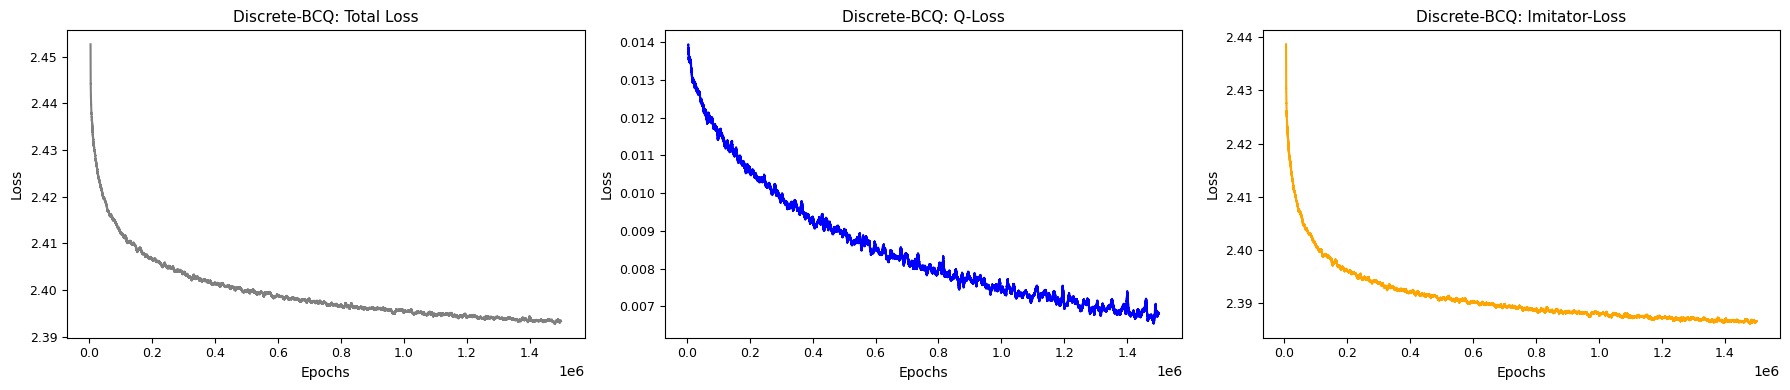

In [54]:
# Smoothing with a window size
window_size = 5000
smoothed_losses = smooth(discrete_bcq_agent.losses, window_size)
smoothed_q_losses = smooth(discrete_bcq_agent.q_losses, window_size)
smoothed_imitator_losses = smooth(discrete_bcq_agent.behavior_losses, window_size)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  

ax1.plot(range(window_size-1, len(discrete_bcq_agent.losses)), smoothed_losses, label="Total Loss", color="gray")
ax1.set_xlabel("Epochs", size=10)
ax1.set_ylabel("Loss", size=10)
ax1.set_title("Discrete-BCQ: Total Loss", size=11)
ax1.tick_params(labelsize=9)

ax2.plot(range(window_size-1, len(discrete_bcq_agent.q_losses)), smoothed_q_losses, label="Q-Loss", color="blue")
ax2.set_xlabel("Epochs", size=10)
ax2.set_ylabel("Loss", size=10)
ax2.set_title("Discrete-BCQ: Q-Loss", size=11)
ax2.tick_params(labelsize=9)

ax3.plot(range(window_size-1, len(discrete_bcq_agent.behavior_losses)), smoothed_imitator_losses, label="Imitator Loss", color='orange')
ax3.set_xlabel("Epochs", size=10)
ax3.set_ylabel("Loss", size=10)
ax3.set_title("Discrete-BCQ: Imitator-Loss", size=11)
ax3.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

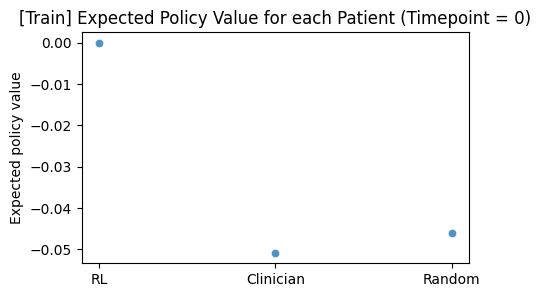

In [33]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

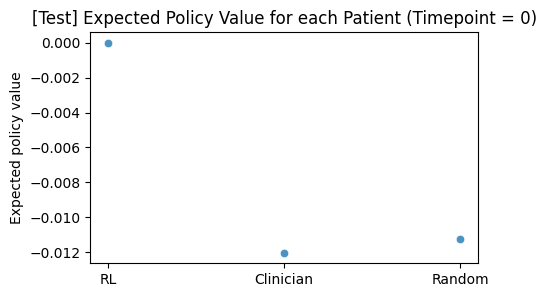

In [34]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_bcq_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/73765664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/73765664.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_RF['agent'] = 'RF'
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/73765664.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

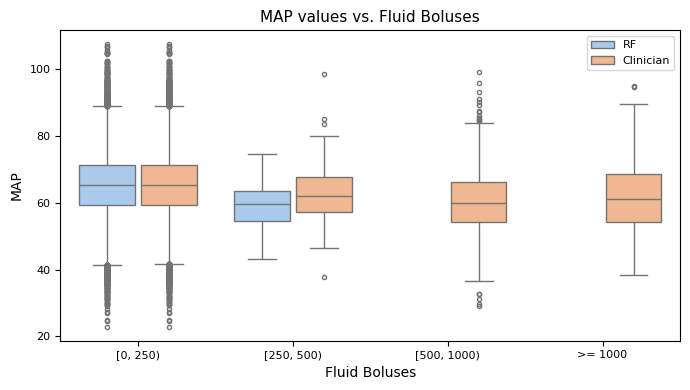

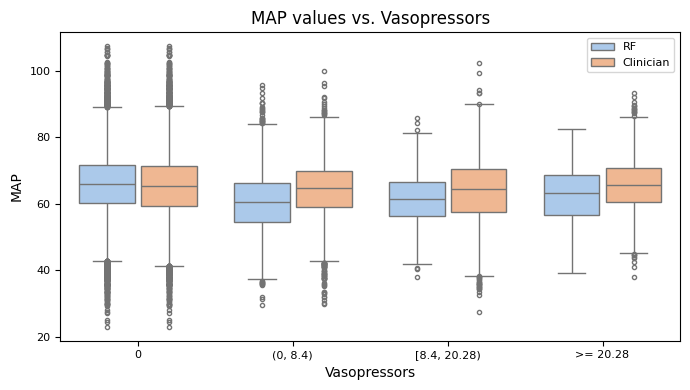

In [56]:
# MAP values for each action taken (test data)
df_boxplot_RF = test_df[['MAP']] # use the original MAP values (before scaling)
df_boxplot_RF['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[state_columns].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_bcq_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_bcq_agent.device)

    with torch.no_grad():
        q_values = discrete_bcq_agent.q_network(state)
        rl_action = torch.argmax(q_values).item()

    df_boxplot_RF.at[index, 'action_number'] = rl_action

df_boxplot_RF['agent'] = 'RF'
df_boxplot_clinician = test_df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_RF, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3)
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Fluid Boluses", size=11)
plt.xlabel("Fluid Boluses", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3, order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Vasopressors")
plt.xlabel("Vasopressors", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

---

### 3. Conservative Q-Learning

Base Model: DoubleDQN

In [38]:
class DiscreteCQL:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, alpha=0.5, target_update_freq=1000, device="mps"):
        self.gamma = gamma
        self.alpha = alpha
        self.device = device
        self.target_update_freq = target_update_freq

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.target_network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)

        # copy weights to target model
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-4)

        # losses
        self.td_losses = []
        self.conservative_losses = []
        self.cql_losses = []

    def compute_loss(self, states, actions, rewards, next_states, dones):
        # 1. calculate bellman error (td error)
        # compute q-values for current states
        q_values = self.q_network(states)
        curr_q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

        # compute next q-values using target network using action selected by current q_network (DDQN framework to reduce overestimation)
        with torch.no_grad():
            next_q_values_q_network = self.q_network(next_states)
            next_actions = next_q_values_q_network.argmax(dim=1)
            next_q_values_target = self.target_network(next_states)
            next_q_values = next_q_values_target.gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        # compute td error
        td_target = rewards + (self.gamma * next_q_values * (1 - dones))
        td_error = F.mse_loss(curr_q_values, td_target)

        # 2. conservative loss: penalize over-estimation of OOD actions
        logsumexp_q_values = torch.logsumexp(q_values, dim=1)
        conservative_loss = (logsumexp_q_values - curr_q_values).mean()

        # 3. total loss
        cql_loss = td_error + self.alpha * conservative_loss
        return cql_loss, td_error, conservative_loss
    
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # compute loss
            cql_loss, td_loss, conservative_loss = self.compute_loss(states, actions, rewards, next_states, dones)

            # optimize
            self.optimizer.zero_grad()
            cql_loss.backward()
            self.optimizer.step()

            # update target network
            if (iteration > 0) and (iteration % self.target_update_freq == 0):
                self.target_network.load_state_dict(self.q_network.state_dict())

            # store and log loss
            self.cql_losses.append(cql_loss.item())
            self.td_losses.append(td_loss.item())
            self.conservative_losses.append(conservative_loss.item())

            if (iteration > 0) and (iteration % 10000 == 0):
                avg_td_loss = sum(self.td_losses[-10000:]) / 10000
                avg_cons_loss = sum(self.conservative_losses[-10000:]) / 10000
                avg_total_loss = sum(self.cql_losses[-10000:]) / 10000
                print(f'[Step {iteration}/{num_steps}] Total Loss: {avg_total_loss:.7f}\tTD Loss: {avg_td_loss:.7f}\tConservative Loss: {avg_cons_loss:.7f}')

    def save_model(self, filepath):
        """Save the Q-network and Target-network to the specified filepath."""
        torch.save({
            'q_network': self.q_network.state_dict(),
            'target_network': self.target_network.state_dict(),
            'optimizer': self.optimizer.state_dict()  # Optional: to save optimizer state too
        }, filepath)

    def load_model(self, filepath):
        """Load the Q-network and Target-network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network'])
        self.target_network.load_state_dict(checkpoint['target_network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])

In [40]:
# train discrete cql agent
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.train(replay_buffer, num_steps=600000)

[Step 10000/600000] Total Loss: 0.7250243	TD Loss: 0.1785530	Conservative Loss: 1.0929426
[Step 20000/600000] Total Loss: 0.6446439	TD Loss: 0.1708578	Conservative Loss: 0.9475722
[Step 30000/600000] Total Loss: 0.6090738	TD Loss: 0.1634275	Conservative Loss: 0.8912927
[Step 40000/600000] Total Loss: 0.5845905	TD Loss: 0.1584159	Conservative Loss: 0.8523492
[Step 50000/600000] Total Loss: 0.5681393	TD Loss: 0.1545982	Conservative Loss: 0.8270823
[Step 60000/600000] Total Loss: 0.5537458	TD Loss: 0.1507599	Conservative Loss: 0.8059719
[Step 70000/600000] Total Loss: 0.5411697	TD Loss: 0.1470933	Conservative Loss: 0.7881530
[Step 80000/600000] Total Loss: 0.5286588	TD Loss: 0.1428564	Conservative Loss: 0.7716047
[Step 90000/600000] Total Loss: 0.5208089	TD Loss: 0.1410346	Conservative Loss: 0.7595486
[Step 100000/600000] Total Loss: 0.5102150	TD Loss: 0.1374523	Conservative Loss: 0.7455254
[Step 110000/600000] Total Loss: 0.5021780	TD Loss: 0.1351636	Conservative Loss: 0.7340288
[Step 12

In [42]:
# continue training
discrete_cql_agent.train(replay_buffer, num_steps=400000)

[Step 10000/400000] Total Loss: 0.3361808	TD Loss: 0.0748855	Conservative Loss: 0.5225907
[Step 20000/400000] Total Loss: 0.3348441	TD Loss: 0.0745885	Conservative Loss: 0.5205112
[Step 30000/400000] Total Loss: 0.3329588	TD Loss: 0.0739134	Conservative Loss: 0.5180908
[Step 40000/400000] Total Loss: 0.3324575	TD Loss: 0.0740733	Conservative Loss: 0.5167683
[Step 50000/400000] Total Loss: 0.3300685	TD Loss: 0.0727686	Conservative Loss: 0.5145998
[Step 60000/400000] Total Loss: 0.3280788	TD Loss: 0.0727278	Conservative Loss: 0.5107019
[Step 70000/400000] Total Loss: 0.3279145	TD Loss: 0.0725054	Conservative Loss: 0.5108181
[Step 80000/400000] Total Loss: 0.3258625	TD Loss: 0.0714509	Conservative Loss: 0.5088232
[Step 90000/400000] Total Loss: 0.3253498	TD Loss: 0.0712950	Conservative Loss: 0.5081096
[Step 100000/400000] Total Loss: 0.3238015	TD Loss: 0.0706854	Conservative Loss: 0.5062321
[Step 110000/400000] Total Loss: 0.3231844	TD Loss: 0.0700353	Conservative Loss: 0.5062983
[Step 12

In [45]:
# continue training
discrete_cql_agent.train(replay_buffer, num_steps=500000)

[Step 10000/500000] Total Loss: 0.2924720	TD Loss: 0.0591838	Conservative Loss: 0.4665765
[Step 20000/500000] Total Loss: 0.2909647	TD Loss: 0.0589034	Conservative Loss: 0.4641225
[Step 30000/500000] Total Loss: 0.2915538	TD Loss: 0.0590076	Conservative Loss: 0.4650924
[Step 40000/500000] Total Loss: 0.2898166	TD Loss: 0.0588098	Conservative Loss: 0.4620137
[Step 50000/500000] Total Loss: 0.2885315	TD Loss: 0.0582449	Conservative Loss: 0.4605731
[Step 60000/500000] Total Loss: 0.2874827	TD Loss: 0.0577139	Conservative Loss: 0.4595375
[Step 70000/500000] Total Loss: 0.2860445	TD Loss: 0.0572986	Conservative Loss: 0.4574919
[Step 80000/500000] Total Loss: 0.2855459	TD Loss: 0.0572979	Conservative Loss: 0.4564960
[Step 90000/500000] Total Loss: 0.2849856	TD Loss: 0.0573947	Conservative Loss: 0.4551817
[Step 100000/500000] Total Loss: 0.2842149	TD Loss: 0.0568743	Conservative Loss: 0.4546813
[Step 110000/500000] Total Loss: 0.2843565	TD Loss: 0.0569247	Conservative Loss: 0.4548637
[Step 12

In [373]:
# transfer to cpu and continue training
def transfer_to_cpu(self):
    """Transfer model from MPS/CUDA to CPU"""
    self.device = "cpu"
    self.q_network = self.q_network.cpu()
    self.target_network = self.target_network.cpu()
    
    # Transfer optimizer state
    for state in self.optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.cpu()

# add method to class
DiscreteCQL.transfer_to_cpu = transfer_to_cpu

In [374]:
# transfer to cpu 
discrete_cql_agent.transfer_to_cpu()

# verify device change
print(f"Q-network device: {next(discrete_cql_agent.q_network.parameters()).device}")
print(f"Target network device: {next(discrete_cql_agent.target_network.parameters()).device}")

Q-network device: cpu
Target network device: cpu


In [47]:
# save model
torch.save(discrete_cql_agent, "DiscreteCQL/cql_agent.pth")
discrete_cql_agent.save_model(filepath="DiscreteCQL/models.pth")

Evaluation:

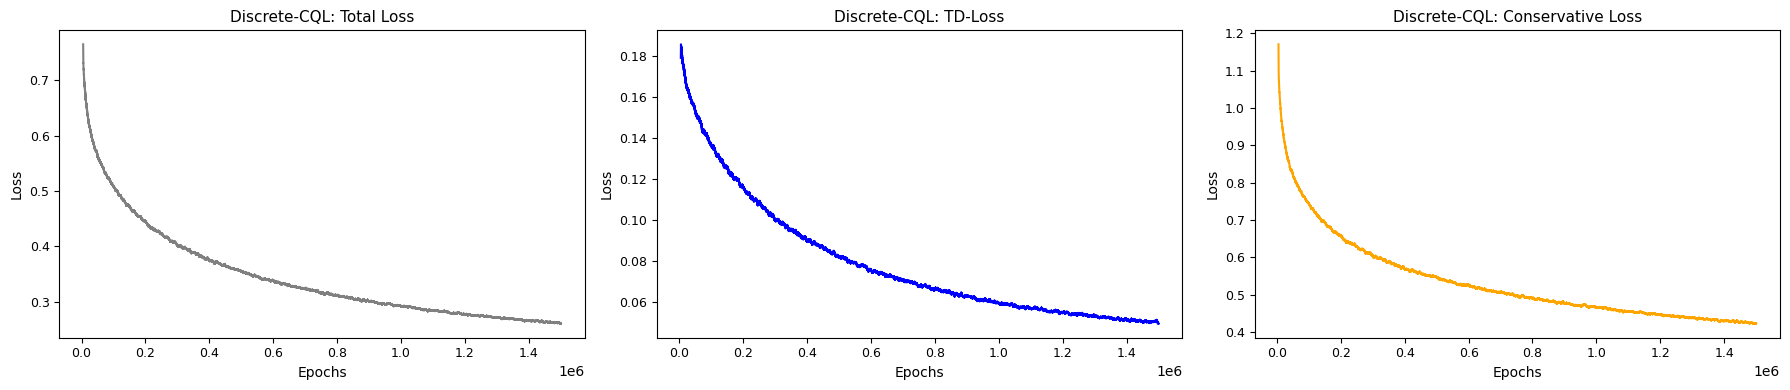

In [46]:
# Smoothing with a window size of 5000
window_size = 5000
smoothed_losses = smooth(discrete_cql_agent.cql_losses, window_size)
smoothed_td_losses = smooth(discrete_cql_agent.td_losses, window_size)
smoothed_cons_losses = smooth(discrete_cql_agent.conservative_losses, window_size)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  

ax1.plot(range(window_size-1, len(discrete_cql_agent.cql_losses)), smoothed_losses, label="Total Loss", color="gray")
ax1.set_xlabel("Epochs", size=10)
ax1.set_ylabel("Loss", size=10)
ax1.set_title("Discrete-CQL: Total Loss", size=11)
ax1.tick_params(labelsize=9)

ax2.plot(range(window_size-1, len(discrete_cql_agent.td_losses)), smoothed_td_losses, label="TD Loss", color="blue")
ax2.set_xlabel("Epochs", size=10)
ax2.set_ylabel("Loss", size=10)
ax2.set_title("Discrete-CQL: TD-Loss", size=11)
ax2.tick_params(labelsize=9)

ax3.plot(range(window_size-1, len(discrete_cql_agent.conservative_losses)), smoothed_cons_losses, label="Conservative Loss", color='orange')
ax3.set_xlabel("Epochs", size=10)
ax3.set_ylabel("Loss", size=10)
ax3.set_title("Discrete-CQL: Conservative Loss", size=11)
ax3.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

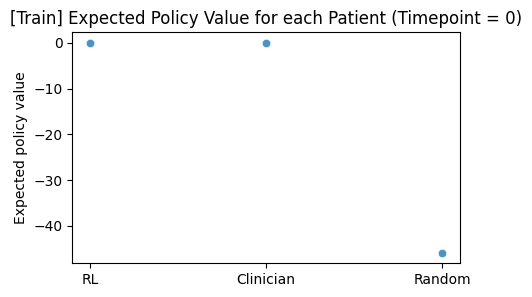

In [48]:
# evaluation on training
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Train] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

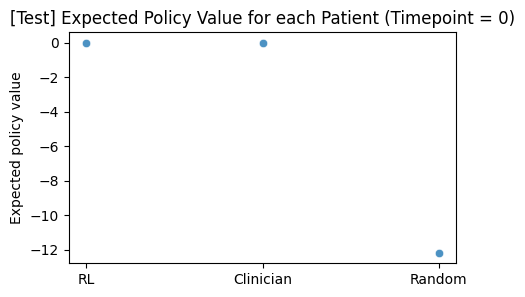

In [49]:
# evaluate for test
Q_RL = 0
Q_random = 0
Q_clinician = 0

# set model to evaluation
discrete_cql_agent.q_network.eval()

for idx, row in X_test_scaled.iterrows():
    if row["hour"] == 0:
        state = np.array(row[state_columns].values)
        state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to(discrete_cql_agent.device)

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            max_q_value = torch.max(q_values).item()
            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()
            random_q_value = np.random.choice(q_values[0].cpu())

            Q_RL += max_q_value
            Q_random += random_q_value
            Q_clinician += clinician_q_value

# normalize by number of patient
Q_RL /= num_patients
Q_clinician /= num_patients
Q_random /= num_patients

# Visualization
plt.figure(figsize=(5, 3))
sns.scatterplot(x=['RL', 'Clinician', 'Random'], y=[Q_RL, Q_clinician, Q_random], alpha=0.8)
plt.ylabel('Expected policy value')
plt.title('[Test] Expected Policy Value for each Patient (Timepoint = 0)')
plt.show()

In [50]:
# MAP values for each action taken (test data)
df_boxplot_CQL = test_df[['MAP']]
df_boxplot_CQL['action_number'] = 0
df_boxplot_BCQ = test_df[["MAP"]]
df_boxplot_BCQ['action_number'] = 0

for index, row in X_test_scaled.iterrows():
    state = np.array(row[state_columns].values)
    state = torch.FloatTensor(state).unsqueeze(0).to(discrete_cql_agent.device)
    action = int(row["action_number"])
    action = torch.LongTensor([action]).to(discrete_cql_agent.device)

    with torch.no_grad():
        q_values_cql = discrete_cql_agent.q_network(state)
        cql_action = torch.argmax(q_values_cql).item()

        q_values_bcq = discrete_bcq_agent.q_network(state)
        bcq_action = torch.argmax(q_values_bcq).item()

    df_boxplot_CQL.at[index, 'action_number'] = cql_action
    df_boxplot_BCQ.at[index, 'action_number'] = bcq_action

df_boxplot_CQL['agent'] = 'CQL'
df_boxplot_BCQ['agent'] = 'BCQ'
df_boxplot_clinician = test_df[['MAP', 'action_number']]
df_boxplot_clinician['agent'] = 'Clinician'
df_boxplot = pd.concat([df_boxplot_CQL, df_boxplot_BCQ, df_boxplot_clinician], ignore_index=True, sort=False)

df_boxplot['fluid_boluses'] = df_boxplot['action_number'].replace(fluid_boluses_dict)
df_boxplot['vasopressors'] = df_boxplot['action_number'].replace(vasopressors_dict)

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/890198051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_CQL['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/890198051.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_boxplot_BCQ['action_number'] = 0
/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_24059/890198051.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

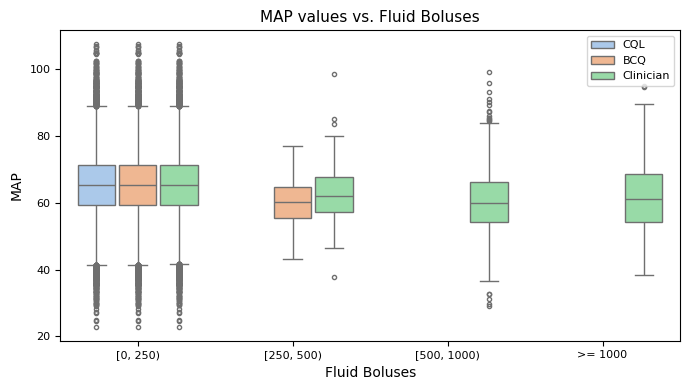

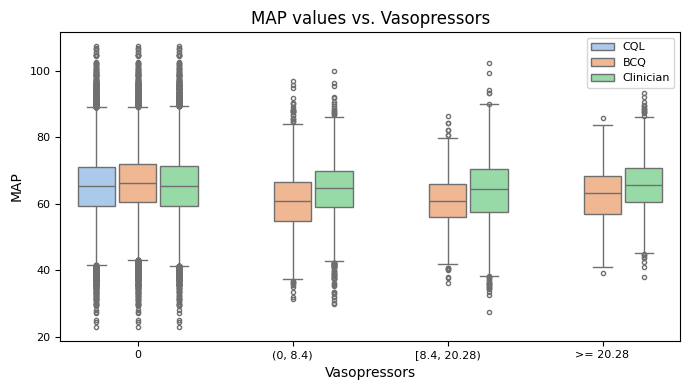

In [51]:
# plot MAP against actions
plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='fluid_boluses', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3, order=['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000'])
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Fluid Boluses", size=11)
plt.xlabel("Fluid Boluses", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
sns.boxplot(y='MAP', x='vasopressors', data=df_boxplot, palette="pastel", hue='agent', gap=.1, fliersize=3, order=['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28'])
plt.legend(loc="upper right", prop={'size': 8})
plt.title("MAP values vs. Vasopressors")
plt.xlabel("Vasopressors", size=10)
plt.ylabel("MAP", size=10)
plt.tick_params(labelsize=8)
plt.tight_layout()
plt.show()

### 4. Distributional DQN

In [366]:
class DistributionalDQN(nn.Module):
    def __init__(self, state_dim, action_dim, num_atoms, v_min, v_max):
        super(DistributionalDQN, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max

        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim * num_atoms)
        
        # Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0)
        
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0)
        
        # Small initialization for output layer
        nn.init.uniform_(self.fc3.weight, -1e-3, 1e-3)  # Even smaller for distributional
        nn.init.uniform_(self.fc3.bias, -1e-3, 1e-3)

        self.register_buffer("supports", torch.linspace(v_min, v_max, num_atoms))

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        dist = x.view(-1, self.action_dim, self.num_atoms)
        return torch.softmax(dist, dim=-1)
    
class DistributionalDQNAgent:
    def __init__(self, state_dim, action_dim, num_atoms=51, v_min=-10, v_max=10, learning_rate=1e-3, gamma=0.99, target_update=10, cql_alpha=0.5):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_atoms = num_atoms
        self.v_min = v_min
        self.v_max = v_max
        self.gamma = gamma
        self.target_update = target_update
        self.cql_alpha = cql_alpha  # CQL regularization parameter

        self.policy_net = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
        self.target_net = DistributionalDQN(state_dim, action_dim, num_atoms, v_min, v_max)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.steps_done = 0

    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            if len(replay_buffer) < replay_buffer.batch_size:
                continue
            
            # Sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            batch_size = states.shape[0]  # Get the actual batch size from the sampled data
            
            # Compute current Q distributions
            current_q_dist = self.policy_net(states)
            current_q_dist_for_taken_actions = current_q_dist[range(batch_size), actions]

            # Compute next Q distributions
            with torch.no_grad():
                next_q_dist = self.target_net(next_states)
                next_actions = (next_q_dist * self.target_net.supports).sum(2).max(1)[1]
                next_q_dist = next_q_dist[range(batch_size), next_actions]

            # Compute projected distribution (Bellman update)
            delta_z = (self.v_max - self.v_min) / (self.num_atoms - 1)
            tz = rewards.unsqueeze(1) + self.gamma * (1 - dones).unsqueeze(1) * self.target_net.supports.unsqueeze(0)
            tz = tz.clamp(self.v_min, self.v_max)
            b = (tz - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            projected_dist = torch.zeros_like(next_q_dist)
            projected_dist.scatter_add_(1, l, next_q_dist * (u.float() - b))
            projected_dist.scatter_add_(1, u, next_q_dist * (b - l.float()))

            # Compute Distributional DQN loss
            dqn_loss = -(projected_dist * torch.log(current_q_dist_for_taken_actions + 1e-8)).sum(1).mean()

            # Compute CQL loss
            q_values = (current_q_dist * self.policy_net.supports).sum(2)
            cql_loss = torch.logsumexp(q_values, dim=1).mean() - q_values.gather(1, actions.unsqueeze(1)).mean()

            # Total loss
            loss = dqn_loss + self.cql_alpha * cql_loss

            # Optimize
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 100)
            self.optimizer.step()

            # Update target network
            if (iteration > 0) and (iteration % self.target_update == 0):
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Log losses
            if hasattr(self, 'losses'):
                self.losses.append(loss.item())
                self.dqn_losses.append(dqn_loss.item())
                self.cql_losses.append(cql_loss.item())
            else:
                self.losses = [loss.item()]
                self.dqn_losses = [dqn_loss.item()]
                self.cql_losses = [cql_loss.item()]

            if (iteration > 0) and (iteration % 10000 == 0):
                avg_loss = sum(self.losses[-10000:]) / 10000
                avg_dqn_loss = sum(self.dqn_losses[-10000:]) / 10000
                avg_cql_loss = sum(self.cql_losses[-10000:]) / 10000
                print(f'[Step {iteration}/{num_steps}] Avg Loss: {avg_loss:.7f}, DQN Loss: {avg_dqn_loss:.7f}, CQL Loss: {avg_cql_loss:.7f}')

    def save_model(self, filepath):
        torch.save(self.policy_net.state_dict(), filepath)

    def load_model(self, filepath):
        self.policy_net.load_state_dict(torch.load(filepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [367]:
# train distributional dqn agent (no gradient clipping)
distributional_dqn_agent = DistributionalDQNAgent(state_dim=18, action_dim=16, num_atoms=51, v_min=v_min, v_max=v_max)
distributional_dqn_agent.train(replay_buffer, num_steps=1000000)

[Step 10000/1000000] Avg Loss: 4.0962992, DQN Loss: 3.8507032, CQL Loss: 0.4911920
[Step 20000/1000000] Avg Loss: 3.8920498, DQN Loss: 3.6809024, CQL Loss: 0.4222948
[Step 30000/1000000] Avg Loss: 3.5967353, DQN Loss: 3.3977612, CQL Loss: 0.3979482
[Step 40000/1000000] Avg Loss: 3.2042718, DQN Loss: 3.0142577, CQL Loss: 0.3800281
[Step 50000/1000000] Avg Loss: 2.4293441, DQN Loss: 2.2465776, CQL Loss: 0.3655329
[Step 60000/1000000] Avg Loss: 1.6003716, DQN Loss: 1.4240465, CQL Loss: 0.3526502
[Step 70000/1000000] Avg Loss: 1.3617178, DQN Loss: 1.1911368, CQL Loss: 0.3411620
[Step 80000/1000000] Avg Loss: 1.2989761, DQN Loss: 1.1337863, CQL Loss: 0.3303795
[Step 90000/1000000] Avg Loss: 1.2657962, DQN Loss: 1.1050169, CQL Loss: 0.3215588
[Step 100000/1000000] Avg Loss: 1.2506317, DQN Loss: 1.0930328, CQL Loss: 0.3151977
[Step 110000/1000000] Avg Loss: 1.2393816, DQN Loss: 1.0844295, CQL Loss: 0.3099042
[Step 120000/1000000] Avg Loss: 1.2377559, DQN Loss: 1.0860644, CQL Loss: 0.3033830
[

In [369]:
# save model
torch.save(distributional_dqn_agent, "DistributionalDQN/distributional_dqn_agent.pth")
distributional_dqn_agent.save_model(filepath="DistributionalDQN/model.pth")

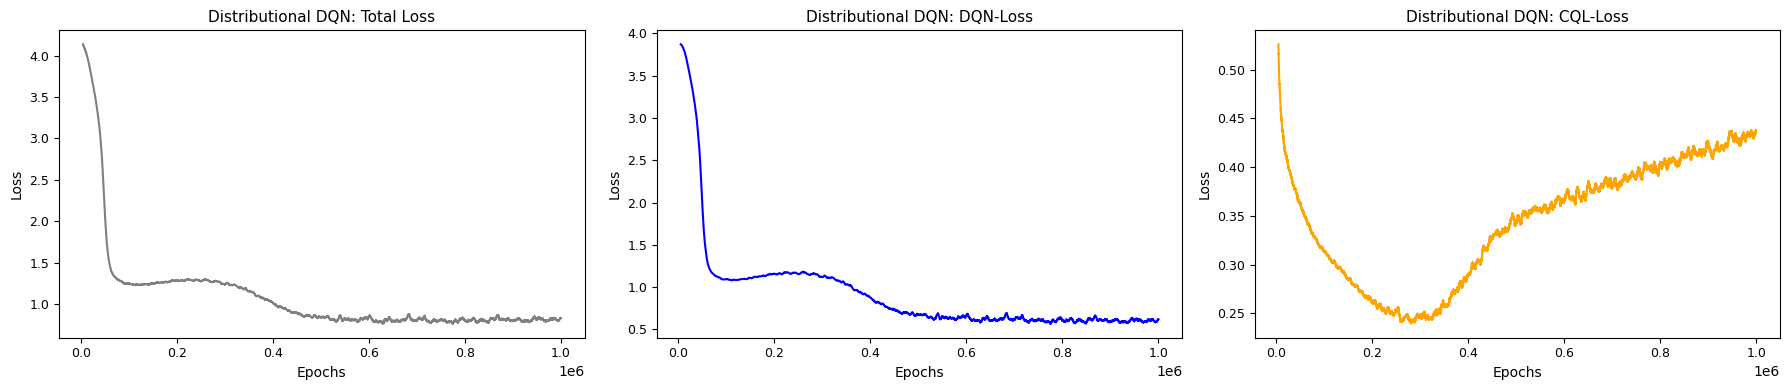

In [368]:
# Smoothing with a window size
window_size = 5000
smoothed_losses = smooth(distributional_dqn_agent.losses, window_size)
smoothed_q_losses = smooth(distributional_dqn_agent.dqn_losses, window_size)
smoothed_imitator_losses = smooth(distributional_dqn_agent.cql_losses, window_size)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))  

ax1.plot(range(window_size-1, len(distributional_dqn_agent.losses)), smoothed_losses, label="Total Loss", color="gray")
ax1.set_xlabel("Epochs", size=10)
ax1.set_ylabel("Loss", size=10)
ax1.set_title("Distributional DQN: Total Loss", size=11)
ax1.tick_params(labelsize=9)

ax2.plot(range(window_size-1, len(distributional_dqn_agent.dqn_losses)), smoothed_q_losses, label="Q-Loss", color="blue")
ax2.set_xlabel("Epochs", size=10)
ax2.set_ylabel("Loss", size=10)
ax2.set_title("Distributional DQN: DQN-Loss", size=11)
ax2.tick_params(labelsize=9)

ax3.plot(range(window_size-1, len(distributional_dqn_agent.cql_losses)), smoothed_imitator_losses, label="Imitator Loss", color='orange')
ax3.set_xlabel("Epochs", size=10)
ax3.set_ylabel("Loss", size=10)
ax3.set_title("Distributional DQN: CQL-Loss", size=11)
ax3.tick_params(labelsize=9)

plt.tight_layout()
plt.show()

___

### Model-Based (Dyna-Q)

Transform to 100 states only:

In [629]:
from sklearn.cluster import KMeans
from sklearn.cross_decomposition import PLSCanonical

In [630]:
# columns for states and actions
actions = ["fluid_boluses", "vasopressors"]
state_columns = ["MAP", "diastolic_bp", "systolic_bp", "urine", "ALT", "AST", "PO2", "lactic_acid", "serum_creatinine", "FiO2", 
          "GCS_total", "urine_m", "ALT_AST_m", "FiO2_m", "GCS_total_m", "PO2_m", "lactic_acid_m", "serum_creatinine_m"]

In [631]:
# cross decomposition to reduce dimensionality
train_df_state = train_df[state_columns]
train_df_action = train_df[actions]
train_df_action = pd.get_dummies(train_df_action, prefix=["fluid_boluses", "vasopressors"], columns=["fluid_boluses", "vasopressors"])

# partial least squares regression
plsca = PLSCanonical(n_components=5)

X = train_df_state.astype(float).values
Y = train_df_action.astype(float).values
X_norm = (X - X.mean(axis=0)) / (X.std(axis=0))
Y_norm = (Y - Y.mean(axis=0)) / (Y.std(axis=0))
X_canonical, Y_canonical = plsca.fit_transform(X_norm, Y_norm)

In [632]:
# k-means clustering to assign each patient to 1 cluster
num_states = 100
kmeans = KMeans(n_clusters=num_states, n_init=10, random_state=42)

state_numbers = kmeans.fit(X_canonical).labels_

We add the following variables:
* `hour`: time point between 0 and 47
* `action_number`: number between 0 and 15 indicating the action taken
* `state_number`: cluster asociated with the state at time t
* `state_number_tp1`: cluster associated with the state at time t+1

In [633]:
# add state number
X_train = train_df.copy()

X_train['state_number'] = state_numbers
X_train['state_number_tp1'] = X_train['state_number'].shift(-1)

X_train.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,PO2,lactic_acid,serum_creatinine,...,lactic_acid_m,serum_creatinine_m,id,hour,reward,action_number,reduced_state,state_num,state_number,state_number_tp1
0,0,67.964940,56.709198,144.578430,241.00052,24.226444,23.811718,83.46306,1.477299,0.893153,...,0,0,0,0,0.00000,0,"[-1.5739360340587958, -2.00511923847156, 0.625...",98,98,23.0
1,1,63.603493,53.635162,143.283780,230.52171,23.933348,30.188170,120.01681,1.733099,0.862924,...,0,0,0,1,0.00000,0,"[-1.267747452046608, -1.6460100854058863, 0.15...",23,23,98.0
2,2,65.750670,56.904236,143.534000,217.76741,21.803823,26.318861,84.16420,1.375228,0.819521,...,0,0,0,2,-0.73454,0,"[-1.6115668181169687, -1.8452429438695837, 0.2...",98,98,4.0
3,3,44.684580,41.952940,117.236534,291.90466,33.613720,24.136852,102.35325,1.252799,0.754315,...,0,0,0,3,0.00000,0,"[-1.1982085046357611, 0.315133115280825, -1.33...",4,4,84.0
4,4,61.486233,63.960106,111.537060,435.26230,45.407272,23.192320,63.73771,1.845126,1.155209,...,0,0,0,4,0.00000,0,"[-0.9862863893288472, -1.6594162126615413, -1....",84,84,40.0


In [634]:
# ignore last hour since we don't observe reward of the last state
X_train = X_train[X_train["hour"] < 47]
X_train["state_number_tp1"] = X_train["state_number_tp1"].astype(int)

A simple algorithm for offline reinforcement learning (where we are given a fixed batch of data and can’t interact with the environment to collect new data) is Batch-Constrained Q-learning (BCQL). It determines an optimal policy in a way similar to standard Q-learning, except that the max over action values in the next state is taken only over actions that have actually been observed in the data.

In [690]:
from sklearn.neighbors import KNeighborsRegressor

class StateProcessor:
    def __init__(self, n_components=5, n_clusters=100):
        self.plsca = PLSCanonical(n_components=n_components)
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        self.X_mean = None
        self.X_std = None
        self.Y_mean = None
        self.Y_std = None
        
    def fit(self, states, actions):
        # Ensure states and actions are DataFrames
        states = pd.DataFrame(states) if not isinstance(states, pd.DataFrame) else states
        actions = pd.DataFrame(actions) if not isinstance(actions, pd.DataFrame) else actions
        
        # Normalize states
        self.X_mean = states.mean(axis=0)
        self.X_std = states.std(axis=0)
        self.X_std = self.X_std.replace(0, 1)  # Handle zero standard deviation
        X_norm = pd.DataFrame((states - self.X_mean) / self.X_std, columns=states.columns)
        
        # Convert actions to dummy variables and normalize
        action_dummies = pd.get_dummies(actions, 
                                      prefix=actions.columns.tolist(), 
                                      columns=actions.columns)
        self.Y_mean = action_dummies.mean(axis=0)
        self.Y_std = action_dummies.std(axis=0)
        self.Y_std = self.Y_std.replace(0, 1)  # Handle zero standard deviation
        Y_norm = pd.DataFrame((action_dummies - self.Y_mean) / self.Y_std, 
                            columns=action_dummies.columns)
        
        # Fit PLS
        X_canonical, Y_canonical = self.plsca.fit_transform(X_norm, Y_norm)
        
        # Fit kmeans on reduced dimensions
        self.kmeans.fit(X_canonical)
        return self
    
    def transform_to_reduced(self, state):
        """Transform a state to its reduced dimension representation"""
        # Ensure state is a DataFrame with column names
        if isinstance(state, pd.Series):
            state = pd.DataFrame(state).T
        elif not isinstance(state, pd.DataFrame):
            state = pd.DataFrame([state], columns=self.X_mean.index)
            
        # Transform state to reduced dimension space
        state_norm = (state - self.X_mean) / self.X_std
        state_canonical = self.plsca.transform(state_norm)
        return state_canonical
    
    def get_state_number(self, reduced_state):
        """Get state number from reduced dimension representation"""
        return self.kmeans.predict(reduced_state)[0]
    
    def transform_state(self, state):
        """Complete pipeline: original state -> reduced dim -> state number"""
        reduced = self.transform_to_reduced(state)
        return self.get_state_number(reduced)
    
    def inverse_transform(self, reduced_state):
        """Transform reduced state back to original space (approximate)"""
        # First transform back from canonical space
        state_norm = self.plsca.inverse_transform(reduced_state)
        # Then denormalize
        state = pd.DataFrame(state_norm * self.X_std.values + self.X_mean.values,
                           columns=self.X_mean.index)
        return state
    
    def get_cluster_centers(self):
        """Get cluster centers in original space"""
        # Transform cluster centers back to original space
        centers_reduced = self.kmeans.cluster_centers_
        return self.inverse_transform(centers_reduced)
    
    def get_state_distribution(self, states):
        """Get distribution of states across clusters"""
        if not isinstance(states, pd.DataFrame):
            states = pd.DataFrame(states, columns=self.X_mean.index)
        reduced_states = self.transform_to_reduced(states)
        cluster_labels = self.kmeans.predict(reduced_states)
        return pd.Series(cluster_labels).value_counts()

In [730]:
print(state_columns)

['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2', 'lactic_acid', 'serum_creatinine', 'FiO2', 'GCS_total', 'urine_m', 'ALT_AST_m', 'FiO2_m', 'GCS_total_m', 'PO2_m', 'lactic_acid_m', 'serum_creatinine_m']


Evaluating PLS components (max possible: 8)...

Components: 1
Explained variance: -0.011
Reconstruction error: 0.771

Components: 2
Explained variance: -0.024
Reconstruction error: 0.587

Components: 3
Explained variance: -0.032
Reconstruction error: 0.475

Components: 4
Explained variance: -0.041
Reconstruction error: 0.380

Components: 5
Explained variance: -0.049
Reconstruction error: 0.308

Components: 6
Explained variance: -0.056
Reconstruction error: 0.244

Components: 7
Explained variance: -0.060
Reconstruction error: 0.192

Components: 8
Explained variance: -0.067
Reconstruction error: 0.137


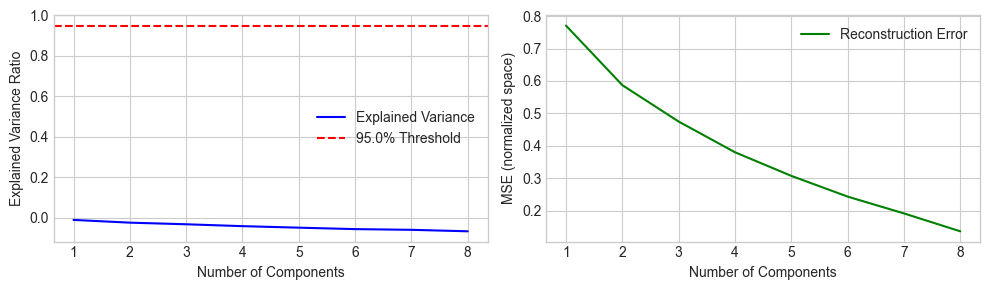


Final Results:
Recommended number of components: 8
Explained variance: -0.067
Reconstruction error (normalized): 0.137


In [732]:
from sklearn.cross_decomposition import PLSRegression

def optimize_pls_components(states, actions, threshold=0.95):
    """
    Find optimal number of PLS components with proper action encoding.
    
    Args:
        states: DataFrame of states
        actions: DataFrame of actions
        threshold: Minimum explained variance threshold (0-1)
    """
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    
    # Normalize states
    X_mean = states.mean(axis=0)
    X_std = states.std(axis=0)
    X_std = X_std.replace(0, 1)  # Handle zero standard deviation
    X_norm = pd.DataFrame((states - X_mean) / X_std, columns=states.columns)
    
    # Convert actions to dummy variables and normalize
    action_dummies = pd.get_dummies(actions, 
                                  prefix=actions.columns.tolist(), 
                                  columns=actions.columns)
    Y_mean = action_dummies.mean(axis=0)
    Y_std = action_dummies.std(axis=0)
    Y_std = Y_std.replace(0, 1)  # Handle zero standard deviation
    Y_norm = pd.DataFrame((action_dummies - Y_mean) / Y_std, 
                         columns=action_dummies.columns)
    
    # Calculate maximum possible components
    max_components = min(
        X_norm.shape[1],    # number of state features
        Y_norm.shape[1],    # number of encoded action features
        X_norm.shape[0]     # number of samples
    )
    
    results = {
        'n_components': [],
        'explained_variance': [],
        'reconstruction_error': []
    }
    
    print(f"Evaluating PLS components (max possible: {max_components})...")
    for n in range(1, max_components + 1):
        # Initialize PLS with n components
        pls = PLSCanonical(n_components=n)
        
        # Fit and transform
        X_reduced = pls.fit_transform(X_norm, Y_norm)[0]
        X_reconstructed = pls.inverse_transform(X_reduced)
        
        # Calculate explained variance
        explained_var = np.sum(pls.score(X_norm, Y_norm)) / X_norm.shape[1]
        
        # Calculate reconstruction error (in normalized space)
        recon_error = mean_squared_error(X_norm, X_reconstructed)
        
        results['n_components'].append(n)
        results['explained_variance'].append(explained_var)
        results['reconstruction_error'].append(recon_error)
        
        print(f"\nComponents: {n}")
        print(f"Explained variance: {explained_var:.3f}")
        print(f"Reconstruction error: {recon_error:.3f}")
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    
    ax1.plot(results['n_components'], results['explained_variance'], 'b-', label='Explained Variance')
    ax1.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100}% Threshold')
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.legend()
    
    ax2.plot(results['n_components'], results['reconstruction_error'], 'g-', label='Reconstruction Error')
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('MSE (normalized space)')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Choose optimal components based on explained variance
    optimal_n_components = max(
        (i for i, var in enumerate(results['explained_variance'], 1)
         if var >= threshold),
        default=max_components
    )
    
    print(f"\nFinal Results:")
    print(f"Recommended number of components: {optimal_n_components}")
    print(f"Explained variance: {results['explained_variance'][optimal_n_components-1]:.3f}")
    print(f"Reconstruction error (normalized): {results['reconstruction_error'][optimal_n_components-1]:.3f}")
    
    return optimal_n_components, results

optimal_components, results = optimize_pls_components(
    train_df[['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'PO2', 'lactic_acid', 'serum_creatinine', 'FiO2', 'GCS_total']], 
    train_df[action_columns],
    threshold=0.95
)

In [692]:
# q-learning with Dyna-Q planning
action_columns = ['fluid_boluses', 'vasopressors']
Q = np.full((100, 16), np.nan, dtype='float') 
Q_orig = Q.copy()

# Initialize state processor and models
state_processor = StateProcessor(n_components=5, n_clusters=100)
state_processor.fit(train_df[state_columns], train_df[action_columns])

# Initialize transition and reward models using reduced state representation
next_state_model = KNeighborsRegressor(n_neighbors=5)

In [693]:
# Prepare data for model training
from tqdm import tqdm

observed_pairs = set()
X_reduced_sa = []  # reduced state-action pairs for model training
y_next_reduced_states = []  # next reduced states for model training
y_rewards = []  # rewards for model training

for index, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Preparing training data"):
    if row["hour"] == 47:
        continue
    state = row[state_columns]
    action = row[action_columns].values
    next_state = train_df.iloc[index + 1][state_columns]
    reward = row['reward']
    
    # Get reduced representations
    state_reduced = state_processor.transform_to_reduced(state).flatten()
    next_state_reduced = state_processor.transform_to_reduced(next_state).flatten()
    
    # Get state numbers for Q-table
    state_number = state_processor.get_state_number(state_reduced.reshape(1, -1))
    
    Q[state_number, int(row['action_number'])] = 0
    observed_pairs.add((state_number, int(row['action_number'])))
    
    # Collect data for model training
    X_reduced_sa.append(np.concatenate([state_reduced, action]))
    y_next_reduced_states.append(next_state_reduced)
    y_rewards.append(reward)

Preparing training data: 100%|██████████| 150144/150144 [06:17<00:00, 398.14it/s]


In [694]:
# convert to numpy arrays
Q_orig = Q.copy()

X_reduced_sa = np.array(X_reduced_sa)
y_next_reduced_states = np.array(y_next_reduced_states)
y_rewards = np.array(y_rewards)

In [697]:
# Train models (transition)
next_state_model.fit(X_reduced_sa, y_next_reduced_states)
#reward_model.fit(X_reduced_sa, y_rewards)

KNeighborsRegressor()

In [699]:
# add state numbers to the DataFrame
train_df['state_number'] = train_df[state_columns].apply(
    lambda x: state_processor.transform_state(x), 
    axis=1
)

In [700]:
# Create lookup dictionary for matching state-action pairs
print("Creating state-action lookup...")
state_action_lookup = {}
for state_num, action_num in observed_pairs:
    matching_rows = train_df[
        (train_df['state_number'] == state_num) & 
        (train_df['action_number'] == action_num)
    ].index.tolist()
    state_action_lookup[(state_num, action_num)] = matching_rows

# Convert to numpy arrays for faster access
states_array = train_df[state_columns].values
actions_array = train_df[action_columns].values
state_numbers_array = train_df["state_number"].values

Creating state-action lookup...


In [702]:
# reward function
def reward_function_row(row):
    if row.MAP > 65: # 0 at >65
        reward = 0
    elif row.MAP > 60: # -0.05 at 60 and 0 at 65
        reward = -0.05 * (65 - row.MAP) / 5
    elif row.MAP > 55: # -0.15 at 55 and -0.05 at 60
        reward = -0.10 * (60 - row.MAP) / 5 - 0.05
    else: # -1 at 40 and -0.15 at 55
        reward = -0.85 * (55 - row.MAP) / 15 - 0.15
    if row.urine > 30 and row.MAP > 55:
        reward = 0
    return reward

In [714]:
# Pre-compute next states and rewards for real experiences
print("Pre-computing transitions...")
next_states = []
rewards = []
valid_indices = []

for index in range(len(train_df)-1):
    row = train_df.iloc[index]
    next_row = train_df.iloc[index + 1]
    
    # Skip boundary conditions
    if row["hour"] == 47 or next_row['id'] != row['id']:
        continue
        
    valid_indices.append(index)
    next_states.append(state_numbers_array[index + 1])
    rewards.append(row['reward'])

# Convert to numpy arrays for efficiency
valid_indices = np.array(valid_indices)
next_states = np.array(next_states)
rewards = np.array(rewards)

print(f"Number of valid transitions: {len(valid_indices)}")

Pre-computing transitions...
Number of valid transitions: 147016


In [709]:
# Pre-compute state-action pairs for planning
print("Pre-computing planning pairs...")
planning_pairs = list(observed_pairs)
planning_lookup = {
    (s, a): state_processor.transform_to_reduced(states_array[
        random.choice(state_action_lookup[(s, a)])
    ]).flatten()
    for s, a in planning_pairs
}

Pre-computing planning pairs...


In [717]:
# parameters
num_iterations = 10
step_size = 0.1
gamma = 0.99
planning_steps = 5
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop with model-based planning
print("Starting Q-learning...")
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    
    # Real experiences - vectorized updates
    for i in tqdm(range(len(valid_indices)), desc=f"Iteration {Q_iter+1}"):
        idx = valid_indices[i]
        state_number = state_numbers_array[idx]
        next_state_number = next_states[i]  # Use i instead of idx
        action_number = int(train_df.iloc[idx]['action_number'])
        reward = rewards[i]
        
        # Q-learning update with real experience
        Q[state_number, action_number] += step_size * (reward + gamma * np.nanmax(Q[next_state_number, :]) - Q[state_number, action_number])
        
        # Planning steps - batch processing
        if planning_steps > 0:
            # Sample multiple state-action pairs at once
            sim_pairs = random.choices(planning_pairs, k=planning_steps)
            
            # Batch predict next states
            sim_states_reduced = np.vstack([
                planning_lookup[pair] for pair in sim_pairs])
            sim_actions = np.vstack([actions_array[random.choice(state_action_lookup[pair])] for pair in sim_pairs])
            
            sim_sa_inputs = np.hstack([sim_states_reduced, sim_actions])
            sim_next_states_reduced = next_state_model.predict(sim_sa_inputs)
            
            # Batch process rewards and updates
            sim_next_states_original = state_processor.inverse_transform(sim_next_states_reduced)
            sim_rewards = np.array([
                reward_function_row(pd.Series({
                    'MAP': row['MAP'],
                    'urine': row['urine']
                }))
                for _, row in sim_next_states_original.iterrows()
            ])
            
            sim_next_state_numbers = np.array([
                state_processor.get_state_number(state_reduced.reshape(1, -1))
                for state_reduced in sim_next_states_reduced
            ])
            
            # Update Q-values for all planning steps at once
            for i in range(planning_steps):
                sim_state_number, sim_action_number = sim_pairs[i]
                Q[sim_state_number, sim_action_number] += step_size * (
                    sim_rewards[i] + gamma * np.nanmax(Q[sim_next_state_numbers[i], :]) - 
                    Q[sim_state_number, sim_action_number]
                )
    
    # Track differences
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))
    print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

Starting Q-learning...


Iteration 1: 100%|██████████| 147016/147016 [06:02<00:00, 405.37it/s]


[Step 0] Difference in Q-values: 0.030933536731401635


Iteration 2: 100%|██████████| 147016/147016 [05:56<00:00, 412.28it/s]


[Step 1] Difference in Q-values: 0.0013430563188864405


Iteration 3: 100%|██████████| 147016/147016 [05:54<00:00, 414.42it/s]


[Step 2] Difference in Q-values: 0.0014355665639794268


Iteration 4: 100%|██████████| 147016/147016 [05:58<00:00, 410.58it/s]


[Step 3] Difference in Q-values: 0.001209960758625216


Iteration 5: 100%|██████████| 147016/147016 [05:56<00:00, 412.59it/s]


[Step 4] Difference in Q-values: 0.00130346189396847


Iteration 6: 100%|██████████| 147016/147016 [05:57<00:00, 410.74it/s]


[Step 5] Difference in Q-values: 0.0013718790334348299


Iteration 7: 100%|██████████| 147016/147016 [05:57<00:00, 411.06it/s]


[Step 6] Difference in Q-values: 0.0011678999315772177


Iteration 8: 100%|██████████| 147016/147016 [05:56<00:00, 411.88it/s]


[Step 7] Difference in Q-values: 0.0011920757037952915


Iteration 9: 100%|██████████| 147016/147016 [06:01<00:00, 406.58it/s]


[Step 8] Difference in Q-values: 0.0013695669127533046


Iteration 10: 100%|██████████| 147016/147016 [06:02<00:00, 405.67it/s]

[Step 9] Difference in Q-values: 0.0013509123310522393


In [720]:
def evaluate_model_accuracy():
    test_indices = np.random.choice(valid_indices, 1000)
    reduced_predictions = []
    reduced_actuals = []
    original_predictions = []
    original_actuals = []
    
    for idx in test_indices:
        state = states_array[idx]
        action = actions_array[idx]
        actual_next_state = states_array[idx + 1]
        
        # Get prediction in reduced space
        state_reduced = state_processor.transform_to_reduced(state).flatten()
        sa_input = np.concatenate([state_reduced, action]).reshape(1, -1)
        predicted_reduced = next_state_model.predict(sa_input)[0]
        
        # Transform prediction back to original space
        predicted_original = state_processor.inverse_transform(
            predicted_reduced.reshape(1, -1)
        ).values[0]
        
        # Get actual in reduced space
        actual_reduced = state_processor.transform_to_reduced(actual_next_state).flatten()
        
        reduced_predictions.append(predicted_reduced)
        reduced_actuals.append(actual_reduced)
        original_predictions.append(predicted_original)
        original_actuals.append(actual_next_state)
    
    # Calculate MSE in reduced space
    reduced_mse = np.mean((np.array(reduced_predictions) - np.array(reduced_actuals)) ** 2)
    
    # Calculate MSE in original space
    original_mse = np.mean((np.array(original_predictions) - np.array(original_actuals)) ** 2)
    
    print(f"Model MSE in reduced space: {reduced_mse:.6f}")
    print(f"Model MSE in original space: {original_mse:.6f}")
    
    # Print MSE for each feature
    feature_mses = np.mean((np.array(original_predictions) - np.array(original_actuals)) ** 2, axis=0)
    for feature, mse in zip(state_processor.X_mean.index, feature_mses):
        print(f"MSE for {feature}: {mse:.6f}")

# Evaluate model
evaluate_model_accuracy()

Model MSE in reduced space: 0.575332
Model MSE in original space: 671.418469
MSE for MAP: 73.401478
MSE for diastolic_bp: 77.350424
MSE for systolic_bp: 136.858125
MSE for urine: 10548.695475
MSE for ALT: 325.954787
MSE for AST: 554.063216
MSE for PO2: 360.583165
MSE for lactic_acid: 0.119735
MSE for serum_creatinine: 0.120716
MSE for FiO2: 0.022853
MSE for GCS_total: 7.831806
MSE for urine_m: 0.186694
MSE for ALT_AST_m: 0.016400
MSE for FiO2_m: 0.069110
MSE for GCS_total_m: 0.146754
MSE for PO2_m: 0.033588
MSE for lactic_acid_m: 0.031680
MSE for serum_creatinine_m: 0.046438


In [721]:
def analyze_error_propagation():
    test_indices = np.random.choice(valid_indices, 1000)
    errors = {
        'pls_reduction': [],  # Error from reducing dimensionality
        'model_prediction': [], # Error from next state prediction
        'pls_reconstruction': [] # Error from reconstructing original space
    }
    
    for idx in test_indices:
        state = states_array[idx]
        action = actions_array[idx]
        actual_next = states_array[idx + 1]
        
        # Step 1: PLS reduction error
        reduced = state_processor.transform_to_reduced(state).flatten()
        reconstructed = state_processor.inverse_transform(reduced.reshape(1, -1)).values[0]
        pls_error = np.mean((state - reconstructed) ** 2)
        
        # Step 2: Model prediction error
        sa_input = np.concatenate([reduced, action]).reshape(1, -1)
        predicted_reduced = next_state_model.predict(sa_input)[0]
        actual_reduced = state_processor.transform_to_reduced(actual_next).flatten()
        pred_error = np.mean((predicted_reduced - actual_reduced) ** 2)
        
        # Step 3: Reconstruction error
        predicted_original = state_processor.inverse_transform(
            predicted_reduced.reshape(1, -1)
        ).values[0]
        recon_error = np.mean((actual_next - predicted_original) ** 2)
        
        errors['pls_reduction'].append(pls_error)
        errors['model_prediction'].append(pred_error)
        errors['pls_reconstruction'].append(recon_error)
    
    for stage, error_list in errors.items():
        print(f"{stage} mean error: {np.mean(error_list):.6f}")
    
    return errors

# Analyze where the error is coming from
errors = analyze_error_propagation()

pls_reduction mean error: 575.235156
model_prediction mean error: 0.549266
pls_reconstruction mean error: 600.401797


In [ ]:
# parameters (continue learning)
num_iterations = 10
diff_tracker_2 = np.zeros((num_iterations, 1))

# q-learning loop with model-based planning
print("Starting Q-learning...")
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    
    # Real experiences - vectorized updates
    for i in tqdm(range(len(valid_indices)), desc=f"Iteration {Q_iter+1}"):
        idx = valid_indices[i]
        state_number = state_numbers_array[idx]
        next_state_number = next_states[i]  # Use i instead of idx
        action_number = int(train_df.iloc[idx]['action_number'])
        reward = rewards[i]
        
        # Q-learning update with real experience
        Q[state_number, action_number] += step_size * (reward + gamma * np.nanmax(Q[next_state_number, :]) - Q[state_number, action_number])
        
        # Planning steps - batch processing
        if planning_steps > 0:
            # Sample multiple state-action pairs at once
            sim_pairs = random.choices(planning_pairs, k=planning_steps)
            
            # Batch predict next states
            sim_states_reduced = np.vstack([
                planning_lookup[pair] for pair in sim_pairs])
            sim_actions = np.vstack([actions_array[random.choice(state_action_lookup[pair])] for pair in sim_pairs])
            
            sim_sa_inputs = np.hstack([sim_states_reduced, sim_actions])
            sim_next_states_reduced = next_state_model.predict(sim_sa_inputs)
            
            # Batch process rewards and updates
            sim_next_states_original = state_processor.inverse_transform(sim_next_states_reduced)
            sim_rewards = np.array([
                reward_function_row(pd.Series({
                    'MAP': row['MAP'],
                    'urine': row['urine']
                }))
                for _, row in sim_next_states_original.iterrows()
            ])
            
            sim_next_state_numbers = np.array([
                state_processor.get_state_number(state_reduced.reshape(1, -1))
                for state_reduced in sim_next_states_reduced
            ])
            
            # Update Q-values for all planning steps at once
            for i in range(planning_steps):
                sim_state_number, sim_action_number = sim_pairs[i]
                Q[sim_state_number, sim_action_number] += step_size * (
                    sim_rewards[i] + gamma * np.nanmax(Q[sim_next_state_numbers[i], :]) - 
                    Q[sim_state_number, sim_action_number]
                )
    
    # Track differences
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))
    print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

In [703]:
# parameters
num_iterations = 5
step_size = 0.1
gamma = 0.99
planning_steps = 2
diff_tracker = np.zeros((num_iterations, 1))

# q-learning loop with model-based planning
print("Starting Q-learning...")
for Q_iter in range(num_iterations):
    Q_old = Q.copy()
    
    # Real experiences
    for index in tqdm(range(len(train_df)-1), desc=f"Iteration {Q_iter+1}"):
        row = train_df.iloc[index]
        
        # Skip boundary conditions
        if row["hour"] == 47 or train_df.iloc[index + 1]['id'] != row['id']:
            continue
            
        state_number = state_numbers_array[index]
        next_state_number = state_numbers_array[index + 1]
        action_number = int(row['action_number'])
        reward = row['reward']
        
        # Q-learning update with real experience
        Q[state_number, action_number] += step_size * (
            reward + gamma * np.nanmax(Q[next_state_number, :]) - Q[state_number, action_number]
        )
        
        # In the planning steps
        for _ in range(planning_steps):
            # Sample state-action pair and get pre-computed matching row
            sim_state_number, sim_action_number = random.choice(list(observed_pairs))
            sim_row_idx = random.choice(state_action_lookup[(sim_state_number, sim_action_number)])
            
            # Get state and action using numpy arrays
            sim_state = states_array[sim_row_idx]
            sim_action = actions_array[sim_row_idx]
            
            # Use model to predict next state
            sim_state_reduced = state_processor.transform_to_reduced(sim_state).flatten()
            sim_sa_input = np.concatenate([sim_state_reduced, sim_action]).reshape(1, -1)
            sim_next_state_reduced = next_state_model.predict(sim_sa_input)[0]
            
            # Convert predicted reduced state back to original space
            sim_next_state_original = state_processor.inverse_transform(sim_next_state_reduced.reshape(1, -1))
            
            # Create a row-like object with the required fields for reward calculation
            sim_next_state_row = pd.Series({
                'MAP': sim_next_state_original['MAP'].iloc[0],
                'urine': sim_next_state_original['urine'].iloc[0]
            })
            
            # Calculate reward using the reward function
            sim_reward = reward_function_row(sim_next_state_row)
            
            # Convert predicted reduced state back to state number
            sim_next_state_number = state_processor.get_state_number(sim_next_state_reduced.reshape(1, -1))
            
            # Q-learning update with simulated experience
            Q[sim_state_number, sim_action_number] += step_size * (
                sim_reward + gamma * np.nanmax(Q[sim_next_state_number, :]) - Q[sim_state_number, sim_action_number]
            )
    # Track differences
    diff_tracker[Q_iter] = np.nanmean(np.abs(Q-Q_old))

    print(f"[Step {Q_iter}] Difference in Q-values: {diff_tracker[Q_iter][0]}")

Starting Q-learning...


Iteration 1: 100%|██████████| 150143/150143 [09:39<00:00, 258.90it/s]


[Step 0] Difference in Q-values: 0.031055067399622455


Iteration 2: 100%|██████████| 150143/150143 [08:51<00:00, 282.65it/s]


[Step 1] Difference in Q-values: 0.006840625036766039


Iteration 3: 100%|██████████| 150143/150143 [08:39<00:00, 288.83it/s]


[Step 2] Difference in Q-values: 0.00795295743196399


Iteration 4: 100%|██████████| 150143/150143 [08:39<00:00, 288.89it/s]


[Step 3] Difference in Q-values: 0.006899432761106186


Iteration 5: 100%|██████████| 150143/150143 [08:35<00:00, 291.52it/s]

[Step 4] Difference in Q-values: 0.006807044194885544


---

In [429]:
# load binned data
binned_df = pd.read_csv('Data/binned_df.csv')
binned_df.head()

,Unnamed: 0,MAP,diastolic_bp,systolic_bp,urine,ALT,AST,p_f_ratio,lactic_acid,serum_creatinine,GCS_total,fluid_boluses,vasopressors,PatientID,Timepoints
0,0,3,1,2,2,0,0,0,0,0,3,0,0,0,0
1,1,2,1,2,2,0,0,1,0,0,3,0,0,0,1
2,2,3,1,2,2,0,0,0,0,0,3,0,0,0,2
3,3,0,1,1,2,0,0,1,0,0,3,0,0,0,3
4,4,2,2,1,2,1,0,0,0,0,3,0,0,0,4


Calculate transitions:

In [430]:
# state and action columns
binned_state_columns = ['MAP', 'diastolic_bp', 'systolic_bp', 'urine', 'ALT', 'AST', 'lactic_acid', 'serum_creatinine', 'p_f_ratio', 'GCS_total']
action_columns = ['fluid_boluses', 'vasopressors']

def create_transitions(df):
    X = []
    y = []
    patients = df['PatientID'].unique()

    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1):
            current_state = patient_records.iloc[i][binned_state_columns]
            next_state = patient_records.iloc[i + 1][binned_state_columns]
            action = patient_records.iloc[i][action_columns]
            X.append(np.concatenate([current_state, action]))
            y.append(next_state)
    return pd.DataFrame(X, columns=binned_state_columns + action_columns), pd.DataFrame(y, columns=binned_state_columns)

In [431]:
# create transitions (model-based --> mb)
X_mb, y_mb = create_transitions(binned_df)

In [432]:
#use K nearest neighbours to calculate next state prediction (function approximation for transitions)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_mb_train, X_mb_test, y_mb_train, y_mb_test = train_test_split(X_mb, y_mb, test_size=0.2, random_state=42)
knn_models = {col: KNeighborsClassifier(n_neighbors=20) for col in binned_state_columns}

for col in binned_state_columns:
    knn_models[col].fit(X_mb_train, y_mb_train[col])

#evaluate accuracy
predictions = pd.DataFrame()
for col in binned_state_columns:
    predictions[col] = knn_models[col].predict(X_mb_test)
    accuracy = accuracy_score(y_mb_test[col], predictions[col])
    print(f"Accuracy for predicting {col}: {accuracy:.2f}")

Accuracy for predicting MAP: 0.50
Accuracy for predicting diastolic_bp: 0.69
Accuracy for predicting systolic_bp: 0.68
Accuracy for predicting urine: 0.71
Accuracy for predicting ALT: 0.81
Accuracy for predicting AST: 0.80
Accuracy for predicting lactic_acid: 0.93
Accuracy for predicting serum_creatinine: 0.85
Accuracy for predicting p_f_ratio: 0.63
Accuracy for predicting GCS_total: 0.89


Get the reward (map from the original dataframe) -- since the reward function is a piecewise linear functio based on MAP and urine.

In [437]:
# use the same reward function (MAP & urine)
binned_df["reward"] = df["reward"]

# use the same encoding for actions
binned_df["action_number"] = df["action_number"]

Split into train and test set:

In [438]:
#train test split
seed = 42
np.random.seed(seed)
train_ratio = 0.8
num_patients = binned_df['PatientID'].nunique()
num_train_samples = int(num_patients * train_ratio)

train_ids = np.random.choice(num_patients, num_train_samples, replace=False)
train_mb_df = binned_df[binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)
test_mb_df = binned_df[~binned_df["PatientID"].isin(train_ids)].reset_index(drop=True)

print(f'Train Data: {train_mb_df.shape}')
print(f'Test Data: {test_mb_df.shape}')

Train Data: (150144, 17)
Test Data: (37536, 17)


Define agent and cumulative returns:

In [734]:
import random
from tqdm import tqdm

# get dictionary
train_state_dict = {tuple(row): idx for idx, row in enumerate(train_mb_df[binned_state_columns].drop_duplicates().values)}

# helper functions
def get_state_index(row, state_columns=binned_state_columns):
    return train_state_dict[tuple(row[state_columns])]

def find_closest_index(input_tuple, train_state_dict=train_state_dict):
    closest_index = None
    min_distance = float("inf")

    # Convert input tuple to numeric array
    input_array = np.array(input_tuple).astype(float)
    
    for state_tuple, index in train_state_dict.items():
        # Convert state tuple to numeric array
        state_array = np.array(state_tuple).astype(float)
        
        # Calculate Euclidean distance
        distance = np.linalg.norm(state_array - input_array)
        
        if distance < min_distance:
            min_distance = distance
            closest_index = index
    
    return closest_index

state_size = len(train_state_dict)
action_size = 16

# return state action pair
def return_state_action_df(row, fluid, vaso):
    state_action = {}
    for col in binned_state_columns:
        state_action[col] = row[col].item()
    
    state_action["fluid_boluses"] = fluid
    state_action["vasopressors"] = vaso
    return pd.DataFrame([state_action])

def clinician_cumulative_reward(df, gamma=0.99):
    patients = df["PatientID"].unique()
    
    total_cumulative_reward = 0
    rewards = []

    for patient in patients:
        patient_reward = 0
        patient_records = df[df['PatientID']==patient].reset_index(drop=True)
        for i in range(len(patient_records) - 1): # 0 to 47 (exclusive of 47)
            reward = patient_records.iloc[i]["reward"].item()
            # times gamma (for patient trajectory)
            patient_reward += (gamma ** i) * reward

        rewards.append(patient_reward)
        total_cumulative_reward += patient_reward

    return total_cumulative_reward, rewards

In [773]:
# reward function for binned values
def get_unbinned_MAP(binned_MAP):
    """
    Convert binned MAP values to representative unbinned values
    MAP bins: 0: <55, 1: 55-60, 2: 60-65, 3: >65
    Using conservative (lower) values for each bin
    """
    MAP_values = {
        0: 50,  # For <55, use 50 as representative
        1: 55,  # For 55-60, use 55
        2: 60,  # For 60-65, use 60
        3: 65   # For >65, use 65
    }
    return MAP_values[binned_MAP]

def get_unbinned_urine(binned_urine):
    """
    Convert binned urine values to representative unbinned values
    Urine bins: 0: <30, 1: 30-50, 2: >50
    Using conservative (lower) values for each bin
    """
    urine_values = {
        0: 25,  # For <30, use 25 as representative
        1: 30,  # For 30-50, use 30
        2: 50   # For >50, use 50
    }
    return urine_values[binned_urine]

def calculate_reward(MAP, urine):
    """Calculate reward based on unbinned MAP and urine values"""
    # First check the special case for urine and MAP
    if urine > 30 and MAP > 55:
        return 0
    
    # Otherwise, calculate reward based on MAP piecewise function
    if MAP > 65:
        return 0
    elif 60 < MAP <= 65:
        return (-0.05 * (65 - MAP)) / 5
    elif 55 < MAP <= 60:
        return (-0.1 * (60 - MAP)) / 5 - 0.05
    else:  # MAP <= 55
        return (-0.85 * (55 - MAP)) / 15 - 0.15

def calculate_reward_from_binned(binned_MAP, binned_urine):
    """Calculate reward using binned values by converting to unbinned first"""
    unbinned_MAP = get_unbinned_MAP(binned_MAP)
    unbinned_urine = get_unbinned_urine(binned_urine)
    return calculate_reward(unbinned_MAP, unbinned_urine)


class DynaQAgent:
    def __init__(self, state_size, action_size, knn_models, gamma=0.99, alpha=0.1, planning_steps=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.alpha = alpha
        self.planning_steps = planning_steps
        self.q_table = np.full((state_size, action_size), np.nan, dtype='float')
        self.knn_models = knn_models
        self.observed_pairs = set()
        self.state_row_cache = {}

    def initialize_q_values(self, train_df):
        """Initialize Q-values and state row cache efficiently"""
        min_reward = np.min(train_df["reward"])
        
        # Pre-compute state row cache more efficiently
        state_groups = train_df.groupby(binned_state_columns).first()
        for state_tuple, row in state_groups.iterrows():
            state_idx = train_state_dict[state_tuple]
            self.state_row_cache[state_idx] = pd.Series(state_tuple, index=binned_state_columns)
        
        # Initialize Q-values efficiently
        states = train_df.apply(lambda row: get_state_index(row), axis=1).values
        actions = train_df['action_number'].astype(int).values
        
        # Initialize all to NaN first
        self.q_table.fill(np.nan)
        
        # Set min_reward for observed pairs
        for state, action in zip(states, actions):
            self.q_table[state, action] = min_reward
            self.observed_pairs.add((state, action))
        
        print(f"Initialized {len(self.observed_pairs)} state-action pairs")
        print(f"Cached {len(self.state_row_cache)} unique states")

    def predict_next_state(self, state_row, action):
        """Use KNN models to predict next state"""
        fluid = action // 4
        vaso = action % 4
        
        state_action_df = return_state_action_df(state_row, fluid, vaso)
        
        predicted_state = {}
        for col in binned_state_columns:
            predicted_state[col] = self.knn_models[col].predict(state_action_df)[0]
        
        return predicted_state

    def calculate_reward(self, predicted_state):
        """Calculate reward based on predicted state"""
        return calculate_reward_from_binned(
            predicted_state['MAP'],
            predicted_state['urine']
        )

    def update(self, state, action, reward, next_state):
        """Update Q-values"""
        next_max_q = np.nanmax(self.q_table[next_state, :])
        self.q_table[state, action] += self.alpha * (
            reward + self.gamma * next_max_q - self.q_table[state, action]
        )


def precompute_transitions(train_df):
    """
    Precompute all valid transitions from the training data.
    
    Args:
        train_df: DataFrame containing training data
        
    Returns:
        dict: Dictionary of patient transitions
        list: List of observed state-action pairs
    """
    print("Precomputing transitions...")
    
    # Initialize containers
    patient_transitions = {}
    observed_pairs = set()
    
    # Process each patient
    for patient_id in tqdm(train_df['PatientID'].unique()):
        patient_data = train_df[train_df['PatientID'] == patient_id].sort_values('Timepoints')
        patient_transitions[patient_id] = []
        
        for i in range(len(patient_data) - 1):
            current_row = patient_data.iloc[i]
            next_row = patient_data.iloc[i + 1]
            
            if current_row['Timepoints'] < 47:
                # Get state indices and action
                current_state = get_state_index(current_row)
                next_state = get_state_index(next_row)
                action = int(current_row['action_number'])
                
                # Store transition
                patient_transitions[patient_id].append({
                    'state': current_state,
                    'action': action,
                    'reward': current_row['reward'],
                    'next_state': next_state
                })
                
                # Add to observed pairs
                observed_pairs.add((current_state, action))
    
    print(f"Processed {len(patient_transitions)} patients")
    print(f"Found {len(observed_pairs)} unique state-action pairs")
    
    return patient_transitions, list(observed_pairs)

def train_dynaQ(agent, patient_transitions, observed_pairs, num_iterations=100):
    """
    Highly optimized DynaQ training with reduced computational load.
    """
    print("Starting DynaQ training...")
    diff_tracker = np.zeros(num_iterations)
    unseen_states_count = 0
    
    # Increase planning interval to reduce frequency
    PLANNING_INTERVAL = 10  # Reduced planning frequency
    
    # Pre-compute and cache frequently used data
    planning_samples = np.array(observed_pairs)
    state_tuple_to_idx = {tuple(agent.state_row_cache[idx]): idx 
                         for idx in agent.state_row_cache}
    
    # Pre-allocate arrays for batch processing
    batch_size = agent.planning_steps
    planning_indices = np.zeros(batch_size, dtype=np.int32)
    
    for iter_num in range(num_iterations):
        q_old = agent.q_table.copy()
        total_planning_steps = 0
        transition_count = 0
        
        # Process real experiences
        for transitions in tqdm(patient_transitions.values(), 
                              desc=f"Iteration {iter_num+1}/{num_iterations}",
                              leave=False):
            # Batch process transitions
            for transition in transitions:
                # Real experience update
                agent.update(
                    transition['state'],
                    transition['action'],
                    transition['reward'],
                    transition['next_state']
                )
                transition_count += 1
                
                # Reduced planning frequency
                if transition_count % PLANNING_INTERVAL == 0:
                    # Generate random indices for planning
                    planning_indices = np.random.randint(
                        0, 
                        len(planning_samples), 
                        size=batch_size
                    )
                    sampled_pairs = planning_samples[planning_indices]
                    
                    # Batch planning steps
                    for sim_state, sim_action in sampled_pairs:
                        sim_state_row = agent.state_row_cache[sim_state]
                        
                        # Skip prediction if we've seen this pair too recently
                        predicted_next_state_dict = agent.predict_next_state(
                            sim_state_row, 
                            sim_action
                        )
                        
                        predicted_state_tuple = tuple(
                            predicted_next_state_dict[col] 
                            for col in binned_state_columns
                        )
                        
                        # Fast lookup with fallback
                        predicted_next_state = state_tuple_to_idx.get(
                            predicted_state_tuple,
                            find_closest_index(predicted_state_tuple)
                        )
                        if predicted_next_state not in state_tuple_to_idx.values():
                            unseen_states_count += 1
                        
                        # Update Q-values
                        sim_reward = agent.calculate_reward(predicted_next_state_dict)
                        agent.update(
                            sim_state, 
                            sim_action, 
                            sim_reward, 
                            predicted_next_state
                        )
                        total_planning_steps += 1
        
        # Efficient difference calculation
        valid_mask = ~np.isnan(agent.q_table)
        diff = np.mean(np.abs(agent.q_table[valid_mask] - q_old[valid_mask]))
        diff_tracker[iter_num] = diff
        
        # Reduced printing frequency
        if (iter_num + 1) % 5 == 0:
            print(f"\n[Step {iter_num+1}/{num_iterations}]")
            print(f"  Q-value difference: {diff:.6f}")
            print(f"  Planning steps: {total_planning_steps}")
            print(f"  Transitions: {transition_count}")
            print(f"  Unseen states: {unseen_states_count}")
    
    return agent, diff_tracker

In [774]:
# 1. Initialize agent
dynaq_agent = DynaQAgent(state_size=state_size, action_size=action_size, 
                   knn_models=knn_models, gamma=0.99, alpha=0.1, planning_steps=5)
dynaq_agent.initialize_q_values(train_mb_df)

Initialized 18282 state-action pairs
Cached 10912 unique states


In [743]:
# 2. Precompute transitions
patient_transitions, observed_pairs = precompute_transitions(train_mb_df)

Precomputing transitions...


100%|██████████| 3128/3128 [01:08<00:00, 45.74it/s]

Processed 3128 patients
Found 18175 unique state-action pairs


In [ ]:
# 3. Train agent
dynaq_agent, diff_tracker = train_dynaQ(dynaq_agent, patient_transitions, observed_pairs, num_iterations=10)

In [535]:
# save agent
torch.save(agent, "Dyna-Q/dynaq_agent.pth")

# Save just the Q-table
np.save('Dyna-Q/q_table.npy', agent.q_table)

# Later, to use it:
#new_agent = DynaQAgent(state_size=state_size, action_size=action_size)
#new_agent.q_table = np.load('trained_q_table.npy')

In [537]:
# calculate dyna-Q reward
def get_policy_probs_dynaq(agent, state):
    """Get action probabilities from Dyna-Q agent's q-table"""
    q_values = agent.q_table[state]
    valid_actions = ~np.isnan(q_values)

    if np.any(valid_actions):
        # Convert Q-values to probabilities using softmax
        valid_q_values = q_values[valid_actions]
        exp_q = np.exp(valid_q_values - np.max(valid_q_values))
        probs = np.zeros_like(q_values)
        probs[valid_actions] = exp_q / np.sum(exp_q)
        return probs
    return np.zeros_like(q_values)

def dynaq_cumulative_reward_with_wis(df, agent, train_state_dict, gamma=0.99):
    patients = df['PatientID'].unique()
    results = {
        'clinician_rewards': [],
        'wis_rewards': [],
        'unseen_states': 0
    }
    
    for patient in patients:
        patient_records = df[df['PatientID'] == patient].reset_index(drop=True)
        patient_wis_reward = 0
        patient_clinician_reward = 0
        
        for i, row in patient_records.iterrows():
            hour = row["Timepoints"]
            if hour == 47:
                continue

            # Get state and handle unseen states
            state_tuple = tuple(row[binned_state_columns])
            if state_tuple not in train_state_dict:
                # Find closest state from training data
                state = find_closest_index(state_tuple, train_state_dict)
                results['unseen_states'] += 1
            else:
                state = train_state_dict[state_tuple]
            
            clinician_action = int(row["action_number"])
            reward = row['reward']
            
            # Get DynaQ policy probabilities for this state
            policy_probs = get_policy_probs_dynaq(agent, state)
            policy_action_prob = policy_probs[clinician_action]
            
            # Calculate WIS
            clinician_action_prob = 0.95
            importance_weight = policy_action_prob / clinician_action_prob
            wis_estimate = importance_weight * reward 

            # Track rewards
            patient_clinician_reward += (gamma ** hour) * reward
            patient_wis_reward += (gamma ** hour) * wis_estimate

        results['wis_rewards'].append(patient_wis_reward)
        results['clinician_rewards'].append(patient_clinician_reward)
    
    return results['clinician_rewards'], results['wis_rewards'], results['unseen_states']

# Create state dictionary from training data only
train_state_dict = {tuple(row): idx for idx, row in enumerate(train_mb_df[binned_state_columns].drop_duplicates().values)}

# Usage
rewards, wis_rewards, unseen_states = dynaq_cumulative_reward_with_wis(
    test_mb_df, agent, train_state_dict, gamma=0.99
)

# Calculate averages
print(f"Average Standard Reward: {np.mean(rewards):.4f}")
print(f"Average WIS Reward: {np.mean(wis_rewards):.4f}")
print(f"Number of unseen states encountered: {unseen_states}")


Average Standard Reward: -2.2443
Average WIS Reward: -0.8666
Number of unseen states encountered: 1125


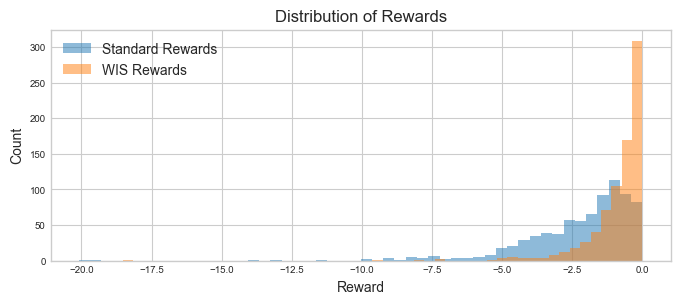

In [538]:
# Plot distributions
plt.figure(figsize=(8, 3))
plt.hist(rewards, alpha=0.5, label='Standard Rewards', bins=50)
plt.hist(wis_rewards, alpha=0.5, label='WIS Rewards', bins=50)
plt.xlabel('Reward')
plt.ylabel('Count')
plt.title('Distribution of Rewards')
plt.legend()
plt.tick_params(labelsize=7)
plt.show()

In [ ]:
# get cumulative reward (based on modeled transitions & reward functions)
    
def calculate_cumulative_reward_model_based(df, agent, train_state_dict, knn_models, gamma=0.99):
    fluid_categories = {
        '[0, 250)': 0,
        '[250, 500)': 1,
        '[500, 1000)': 2,
        '>= 1000': 3
    }
    
    vaso_categories = {
        '0': 0,
        '(0, 8.4)': 1,
        '[8.4, 20.28)': 2,
        '>= 20.28': 3
    }
    patients = df["PatientID"].unique()

    total_cumulative_reward = 0
    rewards = []
    dynaq_map = []
    dynaq_fluids = []
    dynaq_vasopressors = []

    for patient in tqdm(patients):
        patient_reward = 0
        patient_records = df[df["PatientID"]==patient].reset_index(drop=True)
        current_state = patient_records.iloc[0][binned_state_columns]

        for i in range(len(patient_records) - 1):
            # Get current state and handle unseen states
            state_tuple = tuple(current_state)
            if state_tuple not in train_state_dict:
                state_idx = find_closest_index(state_tuple, train_state_dict)
            else:
                state_idx = train_state_dict[state_tuple]
            
            # Get greedy action from Q-table
            q_values = agent.q_table[state_idx]
            valid_actions = ~np.isnan(q_values)
            action = np.argmax(q_values[valid_actions])
            
            # Get fluid and vasopressor values
            fluid, vaso = decode_action(action)
            fluid = fluid_categories[fluid]
            vaso = vaso_categories[vaso]
            dynaq_fluids.append(fluid)
            dynaq_vasopressors.append(vaso)

            # predict next state using KNN models
            predicted_next_state = pd.DataFrame()
            for col in binned_state_columns:
                state_action_df = return_state_action_df(current_state, fluid, vaso)
                predicted_next_state[col] = knn_models[col].predict(state_action_df).astype(int)
            next_state = predicted_next_state

            # calculate reward
            dynaq_map.append(int(current_state["MAP"]))
            next_map = int(next_state["MAP"].item())
            next_urine = int(next_state["urine"].item())
            reward = calculate_reward_from_binned(next_map, next_urine)

            # track rewards
            patient_reward += (gamma ** i) * reward

            # update states
            current_state = next_state.copy().iloc[0]
        
        rewards.append(patient_reward)
        total_cumulative_reward += patient_reward
    return total_cumulative_reward, rewards, dynaq_map, dynaq_fluids, dynaq_vasopressors 

In [ ]:
# get rewards
sample_patients = np.random.choice(test_mb_df["PatientID"].unique(), size=10, replace=False)
test_mb_samples = test_mb_df[test_mb_df["PatientID"].isin(sample_patients)]
print(f"Number of Patients Sampled: {len(sample_patients)}\tNumber of Transitions: {len(test_mb_samples)}")

total_rewards, rewards, map_values, fluids, vasopressors = calculate_cumulative_reward_model_based(
    test_mb_samples, agent, train_state_dict, knn_models
)

# Calculate average reward per patient
num_patients = len(test_mb_samples['PatientID'].unique())
print(f"Average Reward per Patient: {np.mean(rewards):.4f}")

Number of Patients Sampled: 100	Number of Transitions: 4800


100%|██████████| 100/100 [01:32<00:00,  1.08it/s]

Average Reward per Patient: -0.4165


total cumulative reward (dyna Q) per patient with reward: -1.2590066269540632


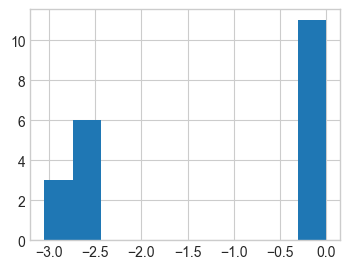

In [416]:
# plot cumulative reward 
plt.figure(figsize=(4, 3))
print("total cumulative reward (dyna Q) per patient with reward:", np.mean(rewards))
plt.hist(rewards)
plt.show()

In [608]:
def get_dynaq_action_distribution(agent, test_df, train_state_dict):
    """Compute the decoded action distribution for the DynaQ agent."""
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))
    
    # Get actions for each state in test data
    predicted_actions = []
    for _, row in test_df.iterrows():
        # Get state and handle unseen states
        state_tuple = tuple(row[binned_state_columns])
        if state_tuple not in train_state_dict:
            state_idx = find_closest_index(state_tuple, train_state_dict)
        else:
            state_idx = train_state_dict[state_tuple]
            
        # Get greedy action from q-table
        q_values = agent.q_table[state_idx]
        valid_actions = ~np.isnan(q_values)

        valid_indices = np.where(valid_actions)[0]
        valid_q_values = q_values[valid_actions]
        action = valid_indices[np.argmax(valid_q_values)]
            
        predicted_actions.append(action)
    
    # Count the occurrences of each fluid-vasopressor combination
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1
    
    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(predicted_actions)
    
    return action_distribution

action_distribution_dynaq = get_dynaq_action_distribution(agent, test_mb_df, train_state_dict)

---

### Evaluation

Load the models:

In [53]:
# Discrete BCQ
discrete_bcq_agent = DiscreteBCQ(state_dim=18, action_dim=16)
discrete_bcq_agent.load_model("DiscreteBCQ/models.pth")

# Discrete CQL
discrete_cql_agent = DiscreteCQL(state_dim=18, action_dim=16)
discrete_cql_agent.load_model("DiscreteCQL/models.pth")

# Distributional DQN
distributional_dqn_agent = DistributionalDQNAgent(state_dim=18, action_dim=16)
distributional_dqn_agent.load_model("DistributionalDQN/model.pth")

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_75722/3184637452.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_locat

Evaluation metrics:

1. Off-Policy Evaluation: Estimate the performance of a policy without interacting with the environment. 

    * **Weighted Importance Sampling**: Calculate the expected reward using a weighted sum of observed rewards, with the weights based on how likely the actions taken by the clinician are under the learned policy. Good performance on WIS suggests that the policy performs well in regions of the state-action space where the clinician policy overlaps with your learned policy.

2. **Policy Value Estimation**: Estimate the expected return (cumulative rewards) of each policy using offline data. Since you have trained on historical data, this gives an idea of how well the policies would perform if deployed. If one model consistently has a higher estimated policy value, it indicates that it may provide better clinical outcomes.

3. **Action Alignment with Clinician**: Comparing the actions taken by each model with those taken by clinicians gives insight into how much the models diverge from clinical practice. A high alignment suggests the model is conservative and safe, while divergence might indicate novel, potentially riskier strategies.

4. **Statistical Testing**: Use statistical tests to assess if differences between the clinician policy and learned policies are significant. For example, a paired t-test or Mann-Whitney U test could be used to compare the rewards associated with each policy. If the learned policies significantly outperform or match the clinician policy, they may represent viable alternatives for decision-making.

5. **Out-of-Distribution (OOD) Performance**: Given that BCQ and CQL are designed to handle OOD states, evaluating their robustness in unseen situations is crucial. This could involve identifying specific patient groups or states that were underrepresented in the training data and checking performance. Robust policies that maintain good performance in OOD states are more suitable for deployment in real-world scenarios with varied patient populations.

6. **Explainability and Action Diversity**: Since CQL penalizes overestimation and BCQ is designed to mimic human actions, you can check how much each policy explores and diverges from typical clinician decisions. Plot the action distribution to visualize where the policies align with or diverge from clinician behavior. If a model explores too much, it may risk patient safety, while low exploration might indicate conservativeness.



---

**1. Weighted Importance Sampling**

For WIS, we need to train a clinician policy to estimate the clinician's action probabilities. This is necessary because we often do not have access to the true clinician action distribution.

Then, we reweight the offline data to simulate how the learned policy would have performed, even though the data was collected using the clinician’s policy. This is crucial for policy evaluation in offline settings where we cannot interact with the environment. Using weighted importance sampling helps reduce the variance of standard importance sampling, which can be high if the evaluation policy differs significantly from the clinician policy. It gives you a more stable estimate of the policy’s value.

In [72]:
# BCQ for discrete actions
class ClinicianAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=128, gamma=0.99, device="mps"):
        self.gamma = gamma
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        self.device = device
        self.network = Q_Network(state_dim, action_dim, hidden_dim).to(self.device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=1e-4)
        self.losses = []
    
    def save_model(self, filepath):
        """Save the network to the specified filepath."""
        torch.save({
            'network': self.network.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, filepath)

    def load_model(self, filepath):
        """Load the network from the specified filepath."""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.network.load_state_dict(checkpoint['network'])
        if 'optimizer' in checkpoint:
            self.optimizer.load_state_dict(checkpoint['optimizer'])
              
    def train(self, replay_buffer, num_steps):
        for iteration in range(num_steps):
            # sample from replay buffer
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            states, actions, rewards, next_states, dones = states.to(self.device), actions.to(self.device), rewards.to(self.device), next_states.to(self.device), dones.to(self.device)

            # behavior cloning (cross-entropy loss with one-hot actions)
            logits = self.network(states)
            log_probs = F.log_softmax(logits, dim=1)
            loss = F.nll_loss(log_probs, actions)

            # update behavior model
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # store loss
            self.losses.append(loss.item())

            if (iteration > 0) and (iteration % 10000 == 0):
                avg_loss = sum(self.losses[-10000:]) / 10000
                print(f'[Step {iteration}/{num_steps}] Loss: {avg_loss:.8f}')

Save the clinician policy:

In [ ]:
# save model
#torch.save(clinician_agent, "Clinician/agent.pth")
#clinician_agent.save_model(filepath="Clinician/model.pth")

Weighted Importance Sampling:

In [83]:
# load agent
clinician_agent = ClinicianAgent(state_dim=18, action_dim=16, hidden_dim=128)
clinician_agent.load_model(filepath="Clinician/model.pth")

/var/folders/_q/fm4rgnc52635tqs2nqp3bnr80000gn/T/ipykernel_33461/3383097341.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath, map_locati

In [382]:
def get_policy_probs(network, states):
    with torch.no_grad():
        if isinstance(network, DistributionalDQNAgent):
            q_dist = network.policy_net(states)
            q_values = (q_dist * network.policy_net.supports).sum(dim=2)
        elif isinstance(network, nn.Module):  # For other neural network models
            q_values = network(states)
        else:
            raise TypeError("Unsupported network type")
        probs = F.softmax(q_values, dim=1).cpu().numpy()
    return probs

def weighted_importance_sampling(policy_network, state, action, reward):
    """Compute weighted importance sampling for policy evaluation"""
    # get probabilities of the actions that were actually taken
    policy_probs = get_policy_probs(policy_network, state.unsqueeze(0))
    policy_action_probs = policy_probs[0, action]

    # assume action taken by the clinician to be rather deterministic 
    # In purely offline settings where no new clinician behavior is available, 
    # treating the observed clinician action as having a probability of 1 can reduce errors that 
    # might arise from an imperfect approximation model for the clinician’s policy. 
    # The alternative—learning a probabilistic clinician model—can sometimes introduce noise, 
    # especially if the offline dataset does not sufficiently capture clinician action patterns.
    # use a smoothed or soft probability instead of setting is as 1.0. 
    clinician_action_probs = 0.95

    # compute importance weights
    importance_weights = policy_action_probs / clinician_action_probs

    # weighted sum of rewards
    weighted_rewards = importance_weights * reward
    return weighted_rewards

def compute_wis_for_trajectory(df, learned_policy, gamma=0.99):
    clinician_rewards = []
    policy_rewards = []

    unique_patients = list(df["id"].unique())
    for id in unique_patients:
        patient_clinician_reward = 0
        patient_policy_reward = 0

        # get the rows for the patient
        patient_df = df[df["id"]==id].reset_index(drop=True)
        
        for i, row in patient_df.iterrows():
            hour = row["hour"]

            # ignore last hour (since reward for last timepoint is captured by 46)
            if hour == 47:
                continue
            reward = row["reward"]
            action = torch.tensor(row["action_number"]).long()
            state = torch.tensor(row[state_columns].values).float() #.to('mps')
            wis_estimate = weighted_importance_sampling(learned_policy, state, action, reward)

            patient_clinician_reward += (gamma ** hour) * reward
            patient_policy_reward += (gamma ** hour) * wis_estimate
        
        clinician_rewards.append(patient_clinician_reward)
        policy_rewards.append(patient_policy_reward)
    
    avg_clinician_rewards = sum(clinician_rewards) / len(clinician_rewards)
    avg_policy_rewards = sum(policy_rewards) / len(policy_rewards)
    return avg_clinician_rewards, avg_policy_rewards, clinician_rewards, policy_rewards


In [542]:
# get expected cumulative rewards
avg_clinician_rewards, avg_bcq_rewards, clinician_rewards, bcq_rewards = compute_wis_for_trajectory(X_test_scaled, discrete_bcq_agent.q_network)
_, avg_cql_rewards, _, cql_rewards = compute_wis_for_trajectory(X_test_scaled, discrete_cql_agent.q_network)
_, avg_dist_dqn_rewards, _, dist_dqn_rewards = compute_wis_for_trajectory(X_test_scaled, distributional_dqn_agent)

print(f'Expected cumulative reward for Clinician Policy: {avg_clinician_rewards}')
print(f'Expected cumulative reward for Discrete BCQ Policy: {avg_bcq_rewards}')
print(f'Expected cumulative reward for Discrete CQL Policy: {avg_cql_rewards}')
print(f'Expected cumulative reward for Distributional DQN Policy: {avg_dist_dqn_rewards}')

Expected cumulative reward for Clinician Policy: -2.2442808015008886
Expected cumulative reward for Discrete BCQ Policy: -0.13914570175123728
Expected cumulative reward for Discrete CQL Policy: -1.5463377965243612
Expected cumulative reward for Distributional DQN Policy: -1.7211993427907013


**2. Action Alignment with Clinician Actions**

In [543]:
def get_policy_actions(policy_network, states):
    """Get the actions predicted by the policy"""
    with torch.no_grad():
        if isinstance(policy_network, DistributionalDQNAgent):
            # Get the distributional Q-values
            q_dist = policy_network.policy_net(states)
            # Compute the expected Q-values by summing over the support
            q_values = (q_dist * policy_network.policy_net.supports).sum(dim=2)  
        else:
            q_values = policy_network(states)

    policy_actions = torch.argmax(q_values, dim=1)
    return policy_actions

def action_alignment(policy_network, states, actions):
    policy_actions = get_policy_actions(policy_network, states)
    alignment = (policy_actions == actions).sum().item() / len(actions)
    return alignment * 100

In [544]:
# check alignment
states = torch.tensor(X_test_scaled[state_columns].values).float()#.to("mps")
actions = torch.tensor(X_test_scaled["action_number"].values).long()#.to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, states, actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, states, actions)
distributional_dqn_alignment = action_alignment(distributional_dqn_agent, states, actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {distributional_dqn_alignment}")

Actions Matched for Discrete BCQ Policy: 70.59622762148338
Actions Matched for Discrete CQL Policy: 82.56606990622336
Actions Matched for Discrete CQL Policy: 84.00468883205457


In [600]:
# get action alignment for dyna-q
def get_policy_actions_dynaq(agent, states, train_state_dict):
    """Get the actions predicted by the Dyna-Q policy"""
    policy_actions = []
    
    for state in states:
        # get state index
        state_tuple = tuple(state)
        if state_tuple not in train_state_dict:
            state_idx = find_closest_index(state_tuple, train_state_dict)
        else:
            state_idx = train_state_dict[state_tuple]

        # Get Q-values for this state
        q_values = agent.q_table[state_idx]
        # Get valid actions (non-NaN Q-values)
        valid_actions = ~np.isnan(q_values)

        valid_indices = np.where(valid_actions)[0]
        valid_q_values = q_values[valid_actions]
        action = valid_indices[np.argmax(valid_q_values)]
             
        policy_actions.append(action)
    
    return np.array(policy_actions)

def action_alignment_dynaq(agent, states, actions, train_state_dict):
    """Calculate action alignment for Dyna-Q agent"""
    policy_actions = get_policy_actions_dynaq(agent, states, train_state_dict)
    alignment = (policy_actions == actions).sum() / len(actions)
    return alignment * 100

test_states_dynaq = test_mb_df[binned_state_columns].values
test_actions_dynaq = test_mb_df["action_number"].values
dynaq_alignment = action_alignment_dynaq(agent, test_states_dynaq, test_actions_dynaq, train_state_dict)
print(f"Action Alignment for Dyna-Q: {dynaq_alignment}")

Action Alignment for Dyna-Q: 18.856564364876384


In [550]:
# Function to decode actions to fluid boluses and vasopressors
def decode_action(action):
    fluid = fluid_boluses_dict[action]
    vasopressor = vasopressors_dict[action]
    return fluid, vasopressor

def get_clinician_action_distribution(clinician_actions):
    """Compute the decoded action distribution for clinician actions."""
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in clinician_actions:
        fluid, vasopressor = decode_action(action)  # Use the same decode_action function
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(clinician_actions)
    return action_distribution

def get_action_distribution(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        if isinstance(policy_network, DistributionalDQNAgent):
            q_dist = policy_network.policy_net(states)
            q_values = (q_dist * policy_network.policy_net.supports).sum(dim=2)
        else:
            q_values = policy_network(states)    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
    # Initialize count matrix
    fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
    vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
    action_count_matrix = np.zeros((len(vasopressor_categories), len(fluid_categories)))

    # Count the occurrences of each fluid-vasopressor combination
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        fluid_idx = fluid_categories.index(fluid)
        vasopressor_idx = vasopressor_categories.index(vasopressor)
        action_count_matrix[vasopressor_idx, fluid_idx] += 1

    # Normalize to get a probability distribution
    action_distribution = action_count_matrix / len(predicted_actions)
    
    return action_distribution

In [551]:
# get action distributions
fluid_categories = ['[0, 250)', '[250, 500)', '[500, 1000)', '>= 1000']  # Sorted fluid boluses
vasopressor_categories = ['0', '(0, 8.4)', '[8.4, 20.28)', '>= 20.28']  # Sorted vasopressors
action_distribution_clinician = get_clinician_action_distribution(np.array(actions.cpu()))
action_distribution_bcq = get_action_distribution(discrete_bcq_agent.q_network, states)
action_distribution_cql = get_action_distribution(discrete_cql_agent.q_network, states)
action_distribution_distributionaldqn = get_action_distribution(distributional_dqn_agent, states)

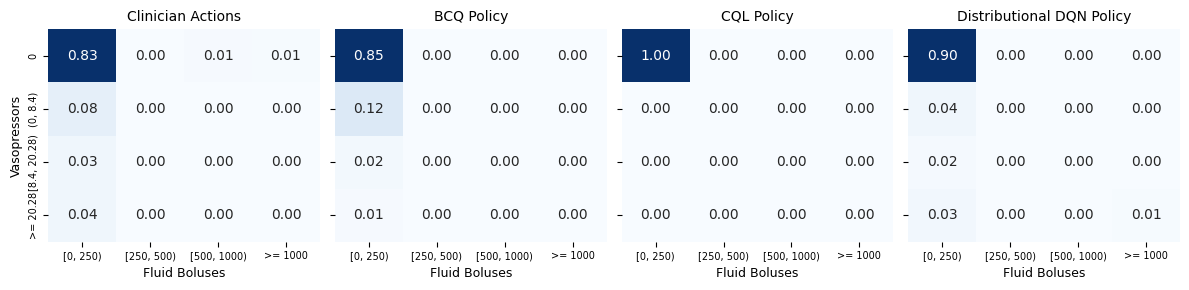

In [390]:
# Plot the action distribution 
fig, axes = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(12, 3))

for i, action_dist in enumerate([action_distribution_clinician, action_distribution_bcq, action_distribution_cql, action_distribution_distributionaldqn]):
    g = sns.heatmap(action_dist, annot=True, cmap="Blues", cbar=False, ax=axes[i], fmt=".2f")
    axes[i].set_xlabel("Fluid Boluses", size=9)
    axes[i].set_xticklabels(fluid_categories, size=7)
    axes[i].set_yticklabels(vasopressor_categories, size=7)
    if i == 0:
        axes[i].set_ylabel("Vasopressors", size=9)
    else:
        axes[i].set_ylabel("")
    
    if i == 0:
        axes[i].set_title("Clinician Actions", size=10)
    elif i == 1:
        axes[i].set_title("BCQ Policy", size=10)
    elif i == 2:
        axes[i].set_title("CQL Policy", size=10)
    elif i == 3:
        axes[i].set_title("Distributional DQN Policy", size=10)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

#cbar = fig.colorbar(g.collections[0], ax=axes, orientation='vertical', shrink=0.8)
#cbar.ax.tick_params(labelsize=7)  # Adjust color bar label size

plt.tight_layout()
plt.show()


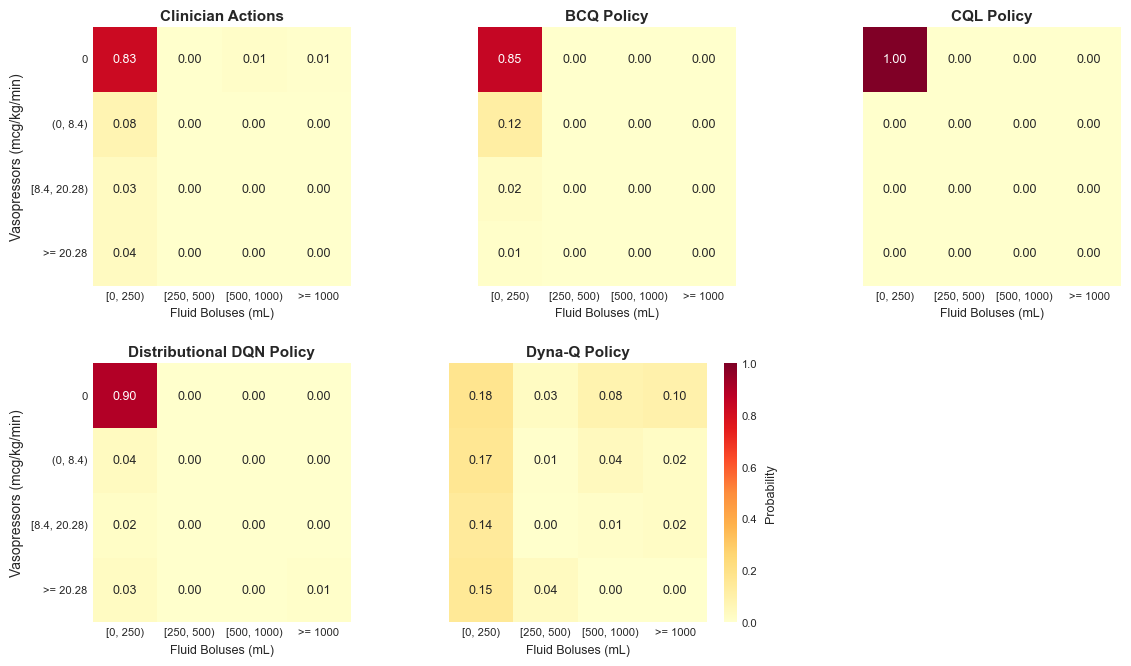

In [587]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')

# Create figure with 2 rows
fig = plt.figure(figsize=(13, 7))

# Create gridspec with adjusted spacing
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1], hspace=0.3, wspace=0.15)  # Increased wspace

# First row: 3 plots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)

# Second row: 2 plots
ax4 = fig.add_subplot(gs[1, 0], sharey=ax1)
ax5 = fig.add_subplot(gs[1, 1], sharey=ax1)

axes = [ax1, ax2, ax3, ax4, ax5]

# Find global min and max for consistent color scaling
all_distributions = [
    action_distribution_clinician, 
    action_distribution_bcq, 
    action_distribution_cql, 
    action_distribution_distributionaldqn,
    action_distribution_dynaq
]
vmin = min(dist.min() for dist in all_distributions)
vmax = max(dist.max() for dist in all_distributions)

titles = [
    "Clinician Actions", 
    "BCQ Policy", 
    "CQL Policy", 
    "Distributional DQN Policy",
    "Dyna-Q Policy"
]

# Create heatmaps
for i, (action_dist, title, ax) in enumerate(zip(all_distributions, titles, axes)):
    g = sns.heatmap(action_dist,
                    annot=True,
                    fmt='.2f',
                    cmap='YlOrRd',
                    cbar=i==4,
                    vmin=vmin,
                    vmax=vmax,
                    ax=ax,
                    annot_kws={'size': 9},
                    square=True)
    
    # Customize axes
    ax.set_xlabel("Fluid Boluses (mL)", size=9, labelpad=5)
    ax.set_xticklabels(fluid_categories, size=8, rotation=0, ha='center')
    
    # Show y-ticks only for leftmost plots in each row
    if i == 0 or i == 3:
        ax.set_ylabel("Vasopressors (mcg/kg/min)", size=10, labelpad=5)
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_yticklabels(vasopressor_categories, size=8, rotation=0)
    else:
        ax.set_ylabel("")
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_yticklabels([])
    
    # Add title
    ax.set_title(title, size=11, pad=5, fontweight='bold')
    
    # If last plot, customize colorbar
    if i == 4:
        cbar = g.collections[0].colorbar
        cbar.ax.set_ylabel('Probability', size=9, labelpad=5)
        cbar.ax.tick_params(labelsize=8)

# Adjust the layout
plt.subplots_adjust(top=0.95, bottom=0.1, left=0.1, right=0.95)

# Make sure y-ticks are visible for leftmost plots
for ax in [axes[0], axes[3]]:
    ax.yaxis.set_visible(True)
    ax.tick_params(axis='y', which='both', left=True, labelleft=True)
    ax.set_yticklabels(vasopressor_categories, size=8, rotation=0)

plt.show()

**Distribution of Q-Values**

In [69]:
q_values_dist_bcq = pd.DataFrame(columns=["id", "hour", "clinician", "bcq"])
discrete_bcq_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_bcq_agent.q_network(state)
            bcq_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist_bcq.loc[len(q_values_dist_bcq)] = [row["id"], row["hour"], clinician_q_value, bcq_q_value]

In [71]:
q_values_dist_cql = pd.DataFrame(columns=["id", "hour", "clinician", "cql"])
discrete_cql_agent.q_network.eval()

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_values = discrete_cql_agent.q_network(state)
            cql_q_value = torch.max(q_values).item()

            clinician_q_value = q_values.gather(1, action.unsqueeze(1)).item()

        q_values_dist_cql.loc[len(q_values_dist_cql)] = [row["id"], row["hour"], clinician_q_value, cql_q_value]

In [73]:
q_values_dist_distdqn = pd.DataFrame(columns=["id", "hour", "clinician", "dist_dqn"])
distributional_dqn_agent.policy_net.eval()  

for _, row in X_test_scaled.iterrows():
    if row["hour"] != 47:
        state = torch.FloatTensor(row[state_columns].values).unsqueeze(0).to("mps")
        action = int(row["action_number"])
        action = torch.LongTensor([action]).to("mps")

        with torch.no_grad():
            q_dist = distributional_dqn_agent.policy_net(state)

            dist_q_value = (q_dist * distributional_dqn_agent.policy_net.supports).sum(dim=2)  
            
            clinician_q_value = dist_q_value.gather(1, action.unsqueeze(1)).item()

        q_values_dist_distdqn.loc[len(q_values_dist_distdqn)] = [row["id"], row["hour"], clinician_q_value, dist_q_value.max().item()]

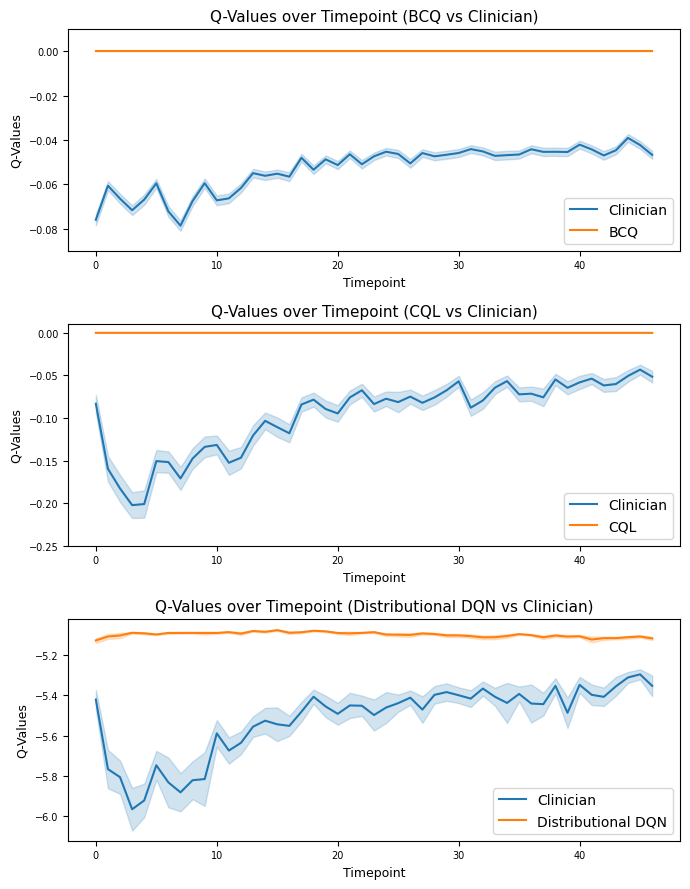

In [98]:
# plotting all in one plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))
axes = axes.flatten()

# bcq
sns.lineplot(x="hour", y="clinician", data=q_values_dist_bcq, errorbar="se", legend=None, ax=axes[0])
sns.lineplot(x="hour", y="bcq", data=q_values_dist_bcq, errorbar="se", legend=None, ax=axes[0])
axes[0].set_title("Q-Values over Timepoint (BCQ vs Clinician)", fontsize=11)
axes[0].set_xlabel("Timepoint", fontsize=9)
axes[0].set_ylabel("Q-Values", fontsize=9)
axes[0].tick_params(labelsize=7)
axes[0].set_ylim([-0.09, 0.01])
axes[0].legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='BCQ')],
           loc="lower right")


# cql 
sns.lineplot(x="hour", y="clinician", data=q_values_dist_cql, errorbar="se", legend=None, ax=axes[1])
sns.lineplot(x="hour", y="cql", data=q_values_dist_cql, errorbar="se", legend=None, ax=axes[1])
axes[1].set_title("Q-Values over Timepoint (CQL vs Clinician)", fontsize=11)
axes[1].set_xlabel("Timepoint", fontsize=9)
axes[1].set_ylabel("Q-Values", fontsize=9)
axes[1].tick_params(labelsize=7)
axes[1].set_ylim([-0.25, 0.01])
axes[1].legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='CQL')],
           loc="lower right")

# distributional dqn 
sns.lineplot(x="hour", y="clinician", data=q_values_dist_distdqn, errorbar="se", ax=axes[2])
sns.lineplot(x="hour", y="dist_dqn", data=q_values_dist_distdqn, errorbar="se", ax=axes[2])
axes[2].set_title("Q-Values over Timepoint (Distributional DQN vs Clinician)", fontsize=11)
axes[2].set_xlabel("Timepoint", fontsize=9)
axes[2].set_ylabel("Q-Values", fontsize=9)
axes[2].tick_params(labelsize=7)
axes[2].legend(handles=[plt.Line2D([0], [0], color=sns.color_palette()[0], label='Clinician'),
                    plt.Line2D([0], [0], color=sns.color_palette()[1], label='Distributional DQN')],
           loc="lower right")
plt.tight_layout()
plt.show()

**3. Identify and Compare performance on OOD States**

In [115]:
import numpy as np

def fit_mahalanobis(training_states):
    # Compute the mean and covariance of the training data
    mean_vector = np.mean(training_states, axis=0)
    cov_matrix = np.cov(training_states, rowvar=False)
    
    # Invert the covariance matrix for Mahalanobis calculation
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    
    return mean_vector, cov_matrix_inv

def calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv):
    distances = []
    for state in test_states:
        diff = state - mean_vector
        distance = np.sqrt(np.dot(np.dot(diff.T, cov_matrix_inv), diff))
        distances.append(distance)
    return np.array(distances)

def identify_ood_states(test_states, training_states, threshold=None):
    # Fit Mahalanobis model
    mean_vector, cov_matrix_inv = fit_mahalanobis(training_states)
    
    # Calculate distances
    distances = calculate_mahalanobis_distance(test_states, mean_vector, cov_matrix_inv)
    
    # Determine threshold if not provided
    if threshold is None:
        # Set threshold as, for example, the 95th percentile of training distances
        train_distances = calculate_mahalanobis_distance(training_states, mean_vector, cov_matrix_inv)
        threshold = np.percentile(train_distances, 95)
    
    # Identify OOD states
    ood_indices = np.where(distances > threshold)[0]
    ood_states = test_states[ood_indices]
    
    return ood_states, ood_indices

In [116]:
# get the states for training and test
training_states = []
for _, row in X_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    training_states.append(state)

test_states = []
for _, row in X_test_scaled.iterrows():
    if row["hour"] == 47:
        continue
    state = np.array(row[state_columns].values)
    test_states.append(state)

training_states = np.array(training_states)
test_states = np.array(test_states)

In [117]:
# get ood states
ood_states, ood_indices = identify_ood_states(test_states, training_states)

In [118]:
# get the data 
X_test_ood = pd.DataFrame(columns=X_test_scaled.columns)
for i, row in X_test_scaled.iterrows():
    if i in ood_indices:
        X_test_ood.loc[len(X_test_ood)] = row

In [119]:
# check alignment
ood_states = torch.tensor(X_test_ood[state_columns].values).float().to("mps")
ood_actions = torch.tensor(X_test_ood["action_number"].values).long().to("mps")
bcq_alignment = action_alignment(discrete_bcq_agent.q_network, ood_states, ood_actions)
cql_alignment = action_alignment(discrete_cql_agent.q_network, ood_states, ood_actions)

print(f"Actions Matched for Discrete BCQ Policy: {bcq_alignment}")
print(f"Actions Matched for Discrete CQL Policy: {cql_alignment}")

Actions Matched for Discrete BCQ Policy: 38.67658373942036
Actions Matched for Discrete CQL Policy: 83.61118235444987


Compare the actions taken at different MAP values:

In [588]:
def categorize_map(row):
    if row.MAP > 65:
        return ">65"
    elif row.MAP > 60:
        return "60-65"
    elif row.MAP > 55:
        return "55-60"
    else:
        return "<55"

# Apply this to the dataset
test_df['MAP_tier'] = test_df.apply(categorize_map, axis=1)

In [589]:
# apply to scaled test
X_test_scaled['MAP_tier'] = np.array(test_df['MAP_tier'])
X_test_scaled['MAP'] = np.array(test_df['MAP'])

In [ ]:
# get test states for model-free
states = torch.tensor(X_test_scaled[state_columns].values).float()
actions = torch.tensor(X_test_scaled["action_number"].values).long()

In [601]:
def get_policy_actions(policy_network, states, policy_type='nn', train_state_dict=None):
    """Get predicted actions from policy network"""
    if policy_type == 'dynaq':
        # Handle DynaQ predictions
        predicted_actions = []
        
        for state in states:
            # get state index
            state_tuple = tuple(state)
            if state_tuple not in train_state_dict:
                state_idx = find_closest_index(state_tuple, train_state_dict)
            else:
                state_idx = train_state_dict[state_tuple]

            # Get Q-values for this state
            q_values = agent.q_table[state_idx]
            # Get valid actions (non-NaN Q-values)
            valid_actions = ~np.isnan(q_values)

            valid_indices = np.where(valid_actions)[0]
            valid_q_values = q_values[valid_actions]
            action = valid_indices[np.argmax(valid_q_values)]
            predicted_actions.append(action)
        predicted_actions = np.array(predicted_actions)
    
    elif policy_type == 'distributional':
        with torch.no_grad():
            q_dist = policy_network.policy_net(states)
            q_values = (q_dist * policy_network.policy_net.supports).sum(dim=2)
            predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
    else:  # standard neural network
        with torch.no_grad():
            q_values = policy_network(states)    
            predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    
    fluids, vasopressors = zip(*[decode_action(action) for action in predicted_actions])
    return np.array(fluids), np.array(vasopressors)

def get_action_proportions(df, policy_name):
    """Calculate action proportions for a given policy by MAP tier"""
    # Group by MAP tier and actions
    action_counts = df.groupby([
        "MAP_tier", 
        f"{policy_name}_fluid", 
        f"{policy_name}_vasopressor"
    ]).size().reset_index(name="count")
    
    # Convert to categorical with ordered categories
    action_counts['MAP_tier'] = pd.Categorical(
        action_counts['MAP_tier'], 
        categories=["<55", "55-60", "60-65", ">65"], 
        ordered=True
    )
    action_counts[f"{policy_name}_fluid"] = pd.Categorical(
        action_counts[f"{policy_name}_fluid"],
        categories=["[0, 250)", "[250, 500)", "[500, 1000)", ">= 1000"],
        ordered=True
    )
    action_counts[f"{policy_name}_vasopressor"] = pd.Categorical(
        action_counts[f"{policy_name}_vasopressor"],
        categories=["0", "(0, 8.4)", "[8.4, 20.28)", ">= 20.28"],
        ordered=True
    )
    
    # Calculate proportions for fluids and vasopressors
    fluid_props = action_counts.groupby(["MAP_tier", f"{policy_name}_fluid"])["count"].sum()\
        .groupby(level=0, group_keys=False).apply(lambda x: x / x.sum())\
        .reset_index(name='proportion')
    
    vaso_props = action_counts.groupby(["MAP_tier", f"{policy_name}_vasopressor"])["count"].sum()\
        .groupby(level=0, group_keys=False).apply(lambda x: x / x.sum())\
        .reset_index(name='proportion')
    
    return fluid_props.rename(columns={f"{policy_name}_fluid": "fluid"}),\
           vaso_props.rename(columns={f"{policy_name}_vasopressor": "vasopressor"})

# Get test data copy
X_test_copy = X_test_scaled.copy()

# Get predicted actions for each policy
X_test_copy["bcq_fluid"], X_test_copy["bcq_vasopressor"] = get_policy_actions(
    discrete_bcq_agent.q_network, states, policy_type='nn')

X_test_copy["cql_fluid"], X_test_copy["cql_vasopressor"] = get_policy_actions(
    discrete_cql_agent.q_network, states, policy_type='nn')

X_test_copy["distributionaldqn_fluid"], X_test_copy["distributionaldqn_vasopressor"] = get_policy_actions(
    distributional_dqn_agent, states, policy_type='distributional')

X_test_copy["dynaq_fluid"], X_test_copy["dynaq_vasopressor"] = get_policy_actions(
    agent, test_states_dynaq, policy_type='dynaq', train_state_dict=train_state_dict)

X_test_copy['clinician_fluid'], X_test_copy['clinician_vasopressor'] = zip(
    *X_test_copy['action_number'].map(decode_action))

# Get proportions for each policy
policies = ['clinician', 'bcq', 'cql', 'distributionaldqn', 'dynaq']
proportions = {}

for policy in policies:
    fluid_props, vaso_props = get_action_proportions(X_test_copy, policy)
    proportions[f"{policy}_fluid"] = fluid_props
    proportions[f"{policy}_vaso"] = vaso_props

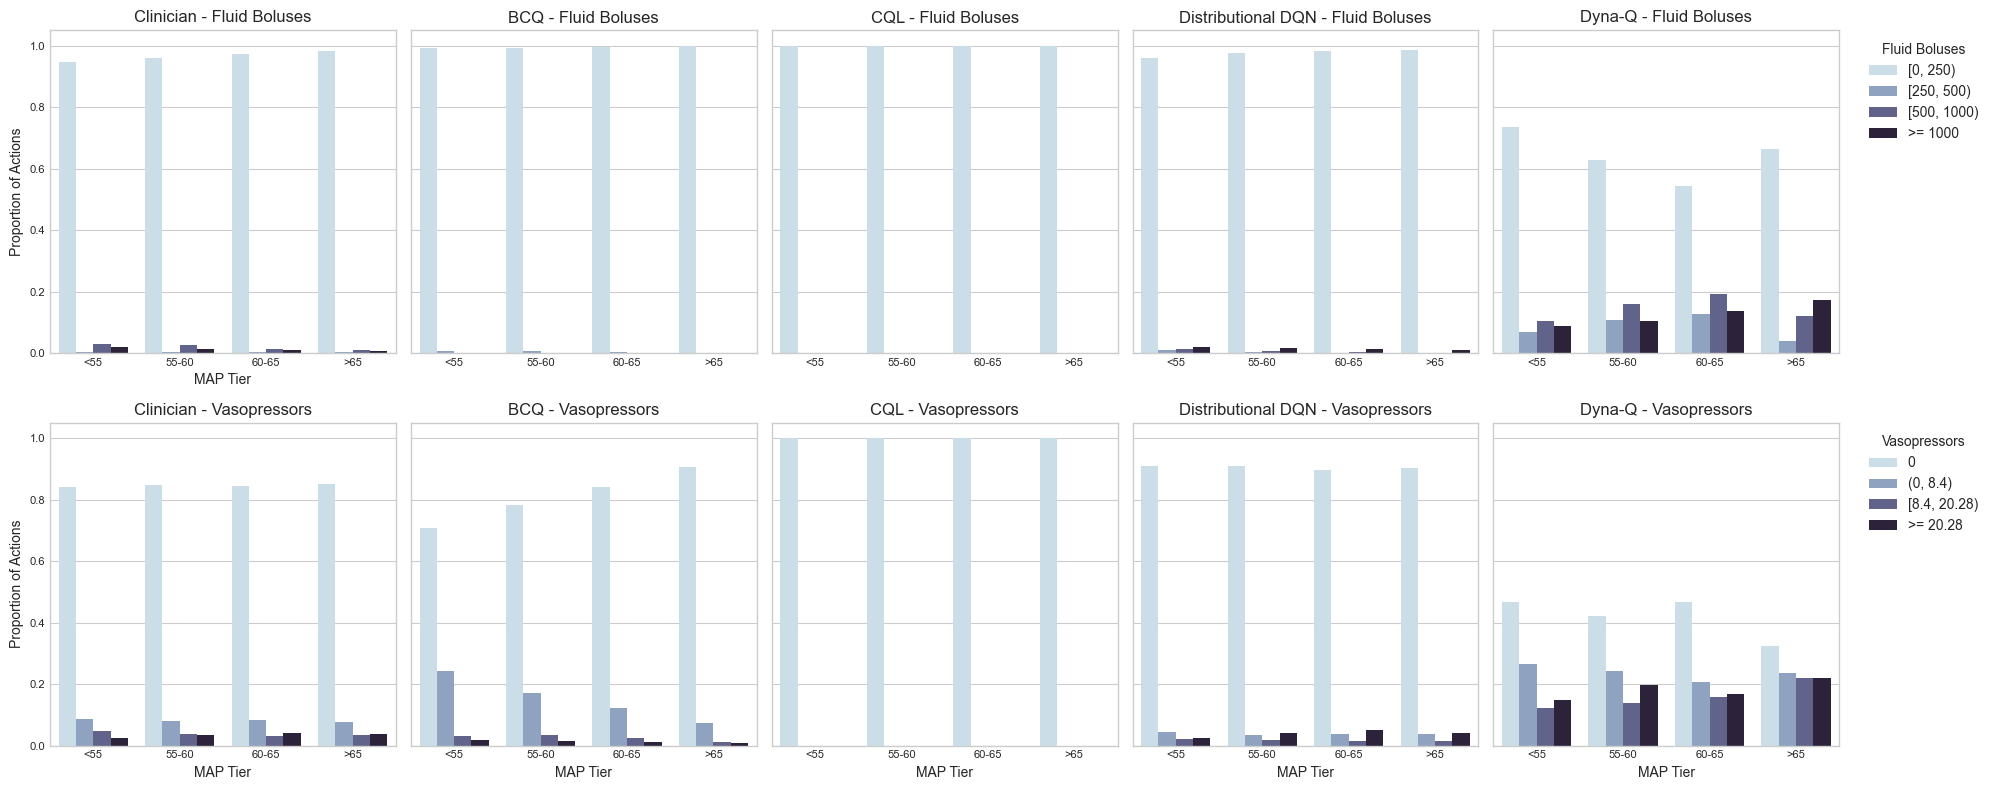

In [604]:
# Create a 2x5 grid
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8), sharey='row')

policy_titles = ["Clinician", "BCQ", "CQL", "Distributional DQN", "Dyna-Q"]

for col, title in enumerate(policy_titles):
    policy_name = title.lower().replace(" ", "").replace("-", "")
    
    # Plot fluid boluses proportions in the first row
    sns.barplot(data=proportions[f"{policy_name}_fluid"], 
                x='MAP_tier', 
                y='proportion', 
                hue='fluid', 
                palette="ch:s=.25,rot=-.25", 
                ax=axes[0, col])
    
    axes[0, col].set_title(f"{title} - Fluid Boluses")
    axes[0, col].set_xlabel("MAP Tier" if col == 0 else "")
    axes[0, col].set_ylabel("Proportion of Actions" if col == 0 else "")
    axes[0, col].tick_params(labelsize=8)
    if col == 4:  # Add legend to the last column plot
        axes[0, col].legend(title="Fluid Boluses", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[0, col].get_legend().remove()
    
    # Plot vasopressor proportions in the second row
    sns.barplot(data=proportions[f"{policy_name}_vaso"], 
                x='MAP_tier', 
                y='proportion', 
                hue='vasopressor', 
                palette="ch:s=.25,rot=-.25", 
                ax=axes[1, col])
    
    axes[1, col].set_title(f"{title} - Vasopressors")
    axes[1, col].set_xlabel("MAP Tier")
    axes[1, col].set_ylabel("Proportion of Actions" if col == 0 else "")
    axes[1, col].tick_params(labelsize=8)
    if col == 4:  # Add legend to the last column plot
        axes[1, col].legend(title="Vasopressors", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1, col].get_legend().remove()

    # Rotate x-tick labels for better readability
    #axes[0, col].tick_params(axis='x', rotation=45)
    #axes[1, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [80]:
# get the predicted action 
def get_action(policy_network, states):
    """Compute the decoded action distribution for the given policy network."""
    with torch.no_grad():
        if isinstance(policy_network, DistributionalDQNAgent):
            q_dist = policy_network.policy_net(states)
            q_values = (q_dist * policy_network.policy_net.supports).sum(dim=2)
        else:
            q_values = policy_network(states)    
    
    predicted_actions = torch.argmax(q_values, dim=1).cpu().numpy()
    predicted_fluids = []
    predicted_vasopressors = []
    for action in predicted_actions:
        fluid, vasopressor = decode_action(action)
        predicted_fluids.append(fluid)
        predicted_vasopressors.append(vasopressor)
    
    return np.array(predicted_fluids), np.array(predicted_vasopressors)

In [81]:
# get the actions
bcq_fluids, bcq_vasopressors = get_action(discrete_bcq_agent.q_network, states)
cql_fluids, cql_vasopressors = get_action(discrete_cql_agent.q_network, states)
distributionaldqn_fluids, distributionaldqn_vasopressors = get_action(distributional_dqn_agent, states)

X_test_copy = X_test_scaled.copy()
X_test_copy["bcq_fluid"] = bcq_fluids
X_test_copy["bcq_vasopressor"] = bcq_vasopressors
X_test_copy["cql_fluid"] = cql_fluids
X_test_copy["cql_vasopressor"] = cql_vasopressors
X_test_copy["distributionaldqn_fluid"] = distributionaldqn_fluids
X_test_copy["distributionaldqn_vasopressor"] = distributionaldqn_vasopressors
X_test_copy['clinician_fluid'], X_test_copy['clinician_vasopressor'] = zip(*X_test_copy['action_number'].map(decode_action))

In [83]:
# group by MAP tier and action type
bcq_action_counts = X_test_copy.groupby(["MAP_tier", "bcq_fluid", "bcq_vasopressor"]).size().reset_index(name="bcq_count")
cql_action_counts = X_test_copy.groupby(["MAP_tier", "cql_fluid", "cql_vasopressor"]).size().reset_index(name="cql_count")
distributionaldqn_action_counts = X_test_copy.groupby(["MAP_tier", "distributionaldqn_fluid", "distributionaldqn_vasopressor"]).size().reset_index(name="distributionaldqn_count")
clinician_action_counts = X_test_copy.groupby(["MAP_tier", "clinician_fluid", "clinician_vasopressor"]).size().reset_index(name="clinician_count")

# Define ordered categories for MAP tiers and actions
map_tier_order = ["<55", "55-60", "60-65", ">65"]
fluid_bolus_order = ["[0, 250)", "[250, 500)", "[500, 1000)", ">= 1000"]
vasopressor_order = ["0", "(0, 8.4)", "[8.4, 20.28)", ">= 20.28"]

# Convert MAP_tier, policy_fluid, and policy_vasopressor columns to categorical with specific ordering
bcq_action_counts['MAP_tier'] = pd.Categorical(bcq_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
bcq_action_counts['bcq_fluid'] = pd.Categorical(bcq_action_counts['bcq_fluid'], categories=fluid_bolus_order, ordered=True)
bcq_action_counts['bcq_vasopressor'] = pd.Categorical(bcq_action_counts['bcq_vasopressor'], categories=vasopressor_order, ordered=True)

cql_action_counts['MAP_tier'] = pd.Categorical(cql_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
cql_action_counts['cql_fluid'] = pd.Categorical(cql_action_counts['cql_fluid'], categories=fluid_bolus_order, ordered=True)
cql_action_counts['cql_vasopressor'] = pd.Categorical(cql_action_counts['cql_vasopressor'], categories=vasopressor_order, ordered=True)

distributionaldqn_action_counts['MAP_tier'] = pd.Categorical(distributionaldqn_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
distributionaldqn_action_counts['distributionaldqn_fluid'] = pd.Categorical(distributionaldqn_action_counts['distributionaldqn_fluid'], categories=fluid_bolus_order, ordered=True)
distributionaldqn_action_counts['distributionaldqn_vasopressor'] = pd.Categorical(distributionaldqn_action_counts['distributionaldqn_vasopressor'], categories=vasopressor_order, ordered=True)

clinician_action_counts['MAP_tier'] = pd.Categorical(clinician_action_counts['MAP_tier'], categories=map_tier_order, ordered=True)
clinician_action_counts['clinician_fluid'] = pd.Categorical(clinician_action_counts['clinician_fluid'], categories=fluid_bolus_order, ordered=True)
clinician_action_counts['clinician_vasopressor'] = pd.Categorical(clinician_action_counts['clinician_vasopressor'], categories=vasopressor_order, ordered=True)

In [93]:
# calculate proportion
def get_action_proportion(action_count_df, policy, action_name):
    counts = action_count_df.groupby(["MAP_tier", f"{policy}_{action_name}"])[f"{policy}_count"].sum()
    proportions = counts.groupby(level=0, group_keys=False).apply(lambda x: x / x.sum()).reset_index(name='proportion')
    proportions = proportions.rename(columns={f"{policy}_{action_name}": action_name})
    return proportions

In [96]:
# get proportions
bcq_fluid_proportions = get_action_proportion(bcq_action_counts, "bcq", "fluid")
bcq_vaso_proportions = get_action_proportion(bcq_action_counts, "bcq", "vasopressor")

cql_fluid_proportions = get_action_proportion(cql_action_counts, "cql", "fluid")
cql_vaso_proportions = get_action_proportion(cql_action_counts, "cql", "vasopressor")

distributionaldqn_fluid_proportions = get_action_proportion(distributionaldqn_action_counts, "distributionaldqn", "fluid")
distributionaldqn_vaso_proportions = get_action_proportion(distributionaldqn_action_counts, "distributionaldqn", "vasopressor")

clinician_fluid_proportions = get_action_proportion(clinician_action_counts, "clinician", "fluid")
clinician_vaso_proportions = get_action_proportion(clinician_action_counts, "clinician", "vasopressor")

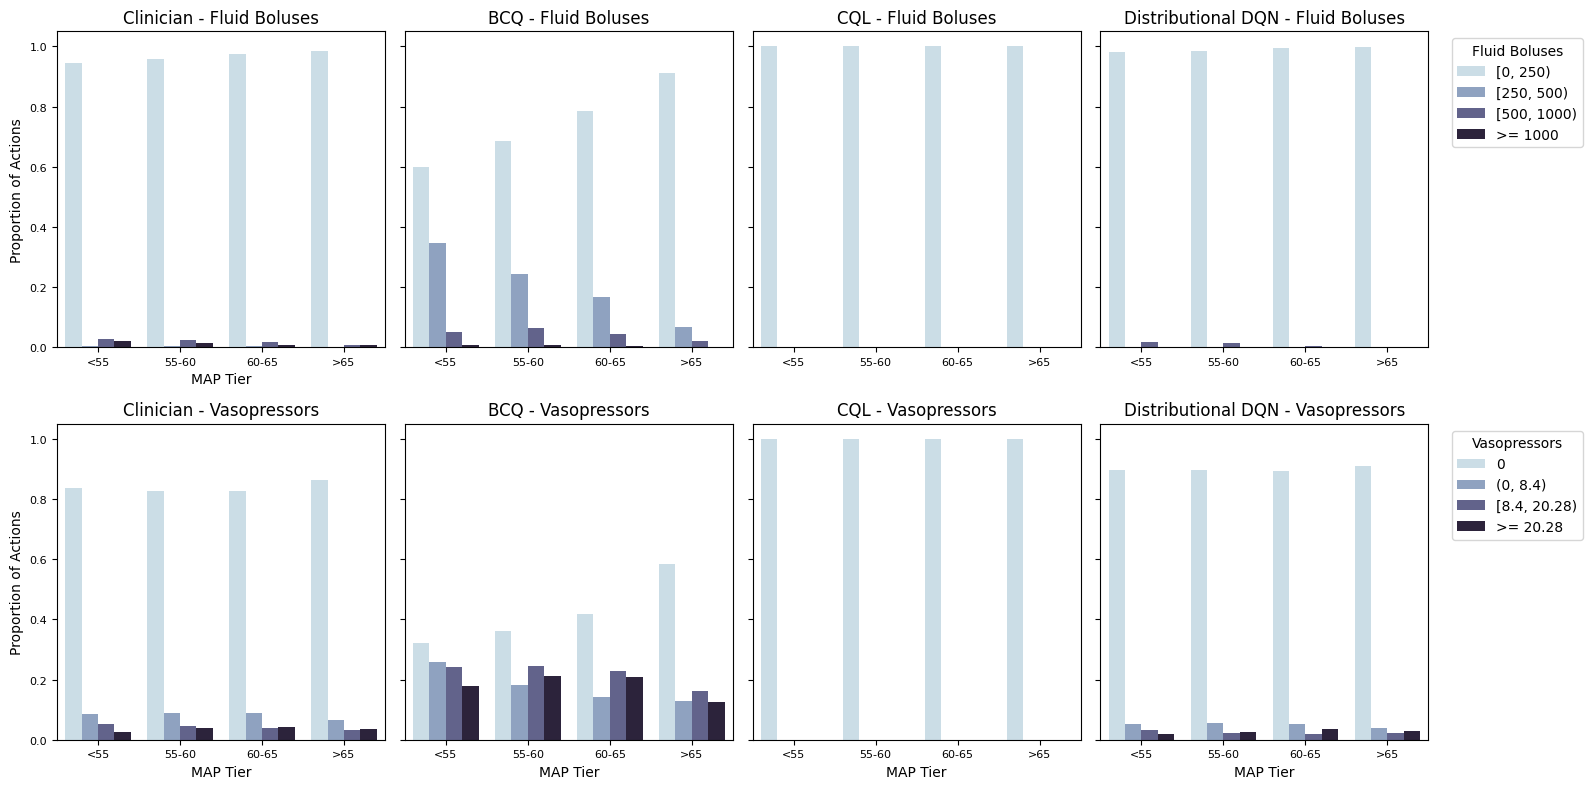

In [97]:
# Combine into lists for easier iteration
fluid_proportions = [clinician_fluid_proportions, bcq_fluid_proportions, cql_fluid_proportions, distributionaldqn_fluid_proportions]
vaso_proportions = [clinician_vaso_proportions, bcq_vaso_proportions, cql_vaso_proportions, distributionaldqn_vaso_proportions]
policy_titles = ["Clinician", "BCQ", "CQL", "Distributional DQN"]

# Create a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8), sharey='row')

for col, (fluid_data, vaso_data, title) in enumerate(zip(fluid_proportions, vaso_proportions, policy_titles)):
    # Plot fluid boluses proportions in the first row
    sns.barplot(data=fluid_data, x='MAP_tier', y='proportion', hue='fluid', 
                palette="ch:s=.25,rot=-.25", ax=axes[0, col])
    axes[0, col].set_title(f"{title} - Fluid Boluses")
    axes[0, col].set_xlabel("MAP Tier" if col == 0 else "")
    axes[0, col].set_ylabel("Proportion of Actions" if col == 0 else "")
    axes[0, col].tick_params(labelsize=8)
    if col == 3:  # Add legend to the last column plot
        axes[0, col].legend(title="Fluid Boluses", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[0, col].get_legend().remove()
    
    # Plot vasopressor proportions in the second row
    sns.barplot(data=vaso_data, x='MAP_tier', y='proportion', hue='vasopressor', 
                palette="ch:s=.25,rot=-.25", ax=axes[1, col])
    axes[1, col].set_title(f"{title} - Vasopressors")
    axes[1, col].set_xlabel("MAP Tier")
    axes[1, col].set_ylabel("Proportion of Actions" if col == 0 else "")
    axes[1, col].tick_params(labelsize=8)
    if col == 3:  # Add legend to the last column plot
        axes[1, col].legend(title="Vasopressors", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        axes[1, col].get_legend().remove()

plt.tight_layout()
plt.show()